In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [ ]:
pip install covid19dh

In [ ]:
from covid19dh import covid19



---
 
# **DANE GLOBALNE**

---





In [ ]:
df, src = covid19(start = datetime(2020,3,20),end = datetime(2022,5,5)) 

We have invested a lot of time and effort in creating COVID-19 Data Hub, please cite the following when using it:

	Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.

A BibTeX entry for LaTeX users is

	@Article{,
		title = {COVID-19 Data Hub},
		year = {2020},
		doi = {10.21105/joss.02376},
		author = {Emanuele Guidotti and David Ardia},
		journal = {Journal of Open Source Software},
		volume = {5},
		number = {51},
		pages = {2376},
	}

To hide this message use 'verbose = False'.


In [ ]:
df.columns

Index(['id', 'date', 'confirmed', 'deaths', 'recovered', 'tests', 'vaccines',
       'people_vaccinated', 'people_fully_vaccinated', 'hosp', 'icu', 'vent',
       'school_closing', 'workplace_closing', 'cancel_events',
       'gatherings_restrictions', 'transport_closing',
       'stay_home_restrictions', 'internal_movement_restrictions',
       'international_movement_restrictions', 'information_campaigns',
       'testing_policy', 'contact_tracing', 'facial_coverings',
       'vaccination_policy', 'elderly_people_protection',
       'government_response_index', 'stringency_index',
       'containment_health_index', 'economic_support_index',
       'administrative_area_level', 'administrative_area_level_1',
       'administrative_area_level_2', 'administrative_area_level_3',
       'latitude', 'longitude', 'population', 'iso_alpha_3', 'iso_alpha_2',
       'iso_numeric', 'iso_currency', 'key_local', 'key_google_mobility',
       'key_apple_mobility', 'key_jhu_csse', 'key_nuts', 'key_g



---


UZUPEŁNIENIE BRAKUJĄCYCH WARTOŚCI


---



Bez pogłębionej analizy można usunąć z zestawu danych zmienne takie jak:'id', 'administrative_area_level',administrative_area_level_1,'administrative_area_level_2','administrative_area_level_3','latitude', 'longitude','iso_alpha_2','iso_currency','iso_numeric', 'iso_currency', 'key_local', 'key_google_mobility', 'key_apple_mobility', 'key_jhu_csse', 'key_nuts', 'key_gadm', ponieważ nie mają one związku z chorobą-dotyczą one m.in obszarów administracyjnych, aktywności rządów, kodów ISO 

In [ ]:
df=df.drop(['id','administrative_area_level','administrative_area_level_1','administrative_area_level_2','administrative_area_level_3','latitude', 'longitude','iso_alpha_2',
            'iso_currency','iso_numeric', 'iso_currency', 'key_local', 'key_google_mobility', 'key_apple_mobility', 'key_jhu_csse', 'key_nuts', 'key_gadm','population'], axis=1)


Usuwam też wszystkie zmienne o charakterze politycznym i ekonomicznym, ponieważ mają one charakter binarny a do predykcji globalnej potrzebuję sumarycznej ilości danych od wszystkich państw i nie są to zmienne ściśle związane z chorobą, nie należą one do zmiennych epidemiologicznych

In [ ]:
df=df.drop(['school_closing', 'workplace_closing', 'cancel_events',
       'gatherings_restrictions', 'transport_closing',
       'stay_home_restrictions', 'internal_movement_restrictions',
       'international_movement_restrictions', 'information_campaigns',
       'testing_policy', 'contact_tracing', 'facial_coverings',
       'vaccination_policy', 'elderly_people_protection',
       'government_response_index', 'stringency_index',
       'containment_health_index', 'economic_support_index'], axis=1)

In [ ]:
def percent_missing(df):
  percent=100*df.isnull().sum()/len(df)
  percent=percent[percent>0].sort_values()
  return percent

In [ ]:
def nan_plot(df):
  percent_nan=percent_missing(df)
  chart=sns.barplot(x=percent_nan.index,y=percent_nan)
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

  for p in chart.patches:
              chart.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                  textcoords='offset points')
  plt.show()

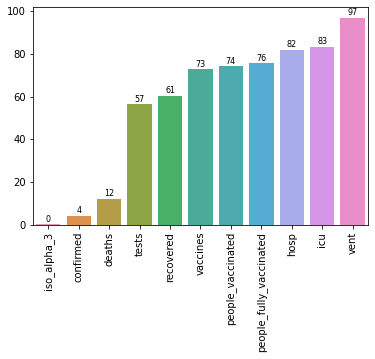

In [ ]:
nan_plot(df)

Braki danych w kolumnach, które są <5 % uważam za całkowicie przypadkowe i usuwam wiersze z tymi danymi.

In [ ]:
percent_nan=percent_missing(df)
df=df.dropna(axis=0,subset=percent_nan[percent_nan<5].index.tolist())

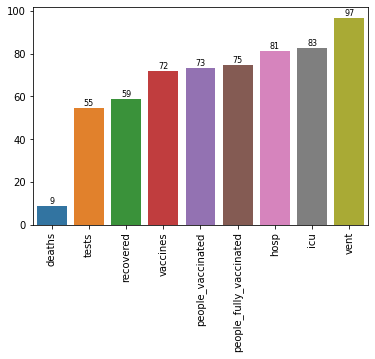

In [ ]:
nan_plot(df)


W kolumnach :'confirmed','deaths'	,'recovered','tests','vaccines','people_vaccinated','people_fully_vaccinated' znajdują się dane skumulowane, które dodatkowo można traktować jako szeregi czasowe. Biorąc to pod uwagę, najlepszą metodą do uzupełnienia braku danych w tych kolumnach będzie interpolacja. Interpolację będę wykonywać w pętli według kraju z którego te dane pochodzą, żeby uzyskać dokładniejsze rezultaty. Wierzsze z wartościami NaN, kórych nie będzie w stanie wypełnić interpolacja zostaną wypełnione metodą ffill()

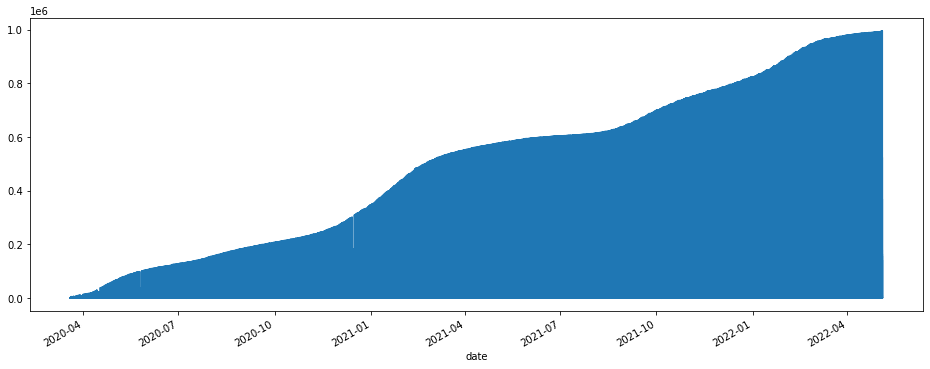

In [ ]:
df.set_index('date')['deaths'].plot(figsize = (16,6))

In [ ]:
for x in df['iso_alpha_3'].unique():
  df.loc[df['iso_alpha_3']==x, 'deaths']=df.loc[df['iso_alpha_3']==x, 'deaths'].interpolate(limit_direction="both")

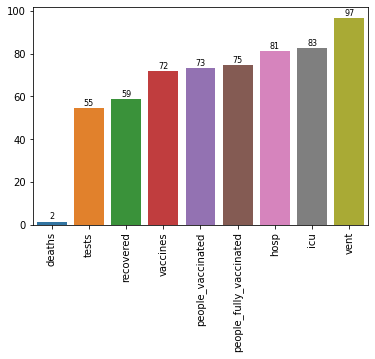

In [ ]:
nan_plot(df)

In [ ]:
df['deaths']=df['deaths'].ffill()

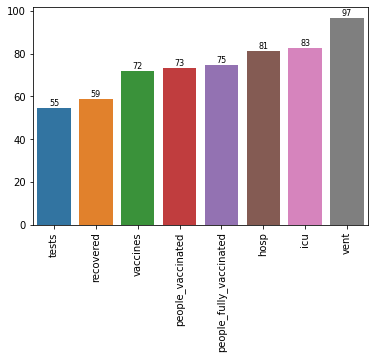

In [ ]:
nan_plot(df)

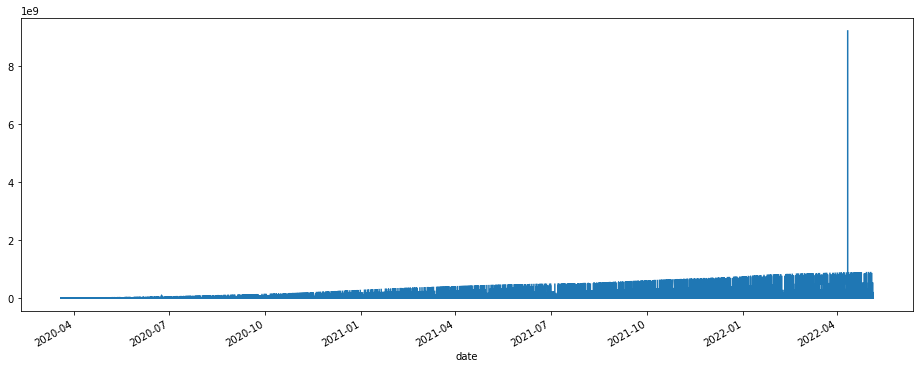

In [ ]:
df.set_index('date')['tests'].plot(figsize = (16,6))


In [ ]:
for x in df['iso_alpha_3'].unique():
  df.loc[df['iso_alpha_3']==x, 'tests']=df.loc[df['iso_alpha_3']==x, 'tests'].interpolate(limit_direction="both")

Po interpolacji ilość brakujących wartości spadła do 17%. Te wartości uznaję jako braki w raportowaniu i wypełniam je wartością z poprzedniego dnia. 

In [ ]:
df['tests']=df['tests'].ffill()

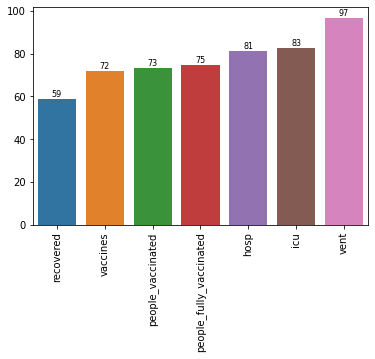

In [ ]:
nan_plot(df)


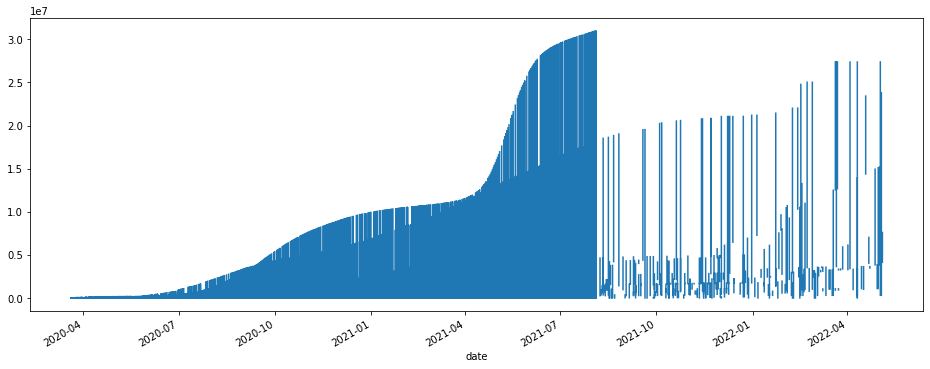

In [ ]:
df.set_index('date')['recovered'].plot(figsize = (16,6))

In [ ]:
for x in df['iso_alpha_3'].unique():
  df.loc[df['iso_alpha_3']==x, 'recovered']=df.loc[df['iso_alpha_3']==x, 'recovered'].interpolate(limit_direction="both")

In [ ]:
df['recovered']=df['recovered'].ffill()

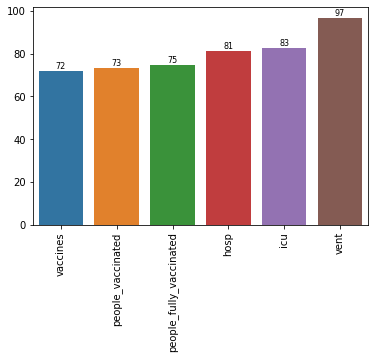

In [ ]:
nan_plot(df)

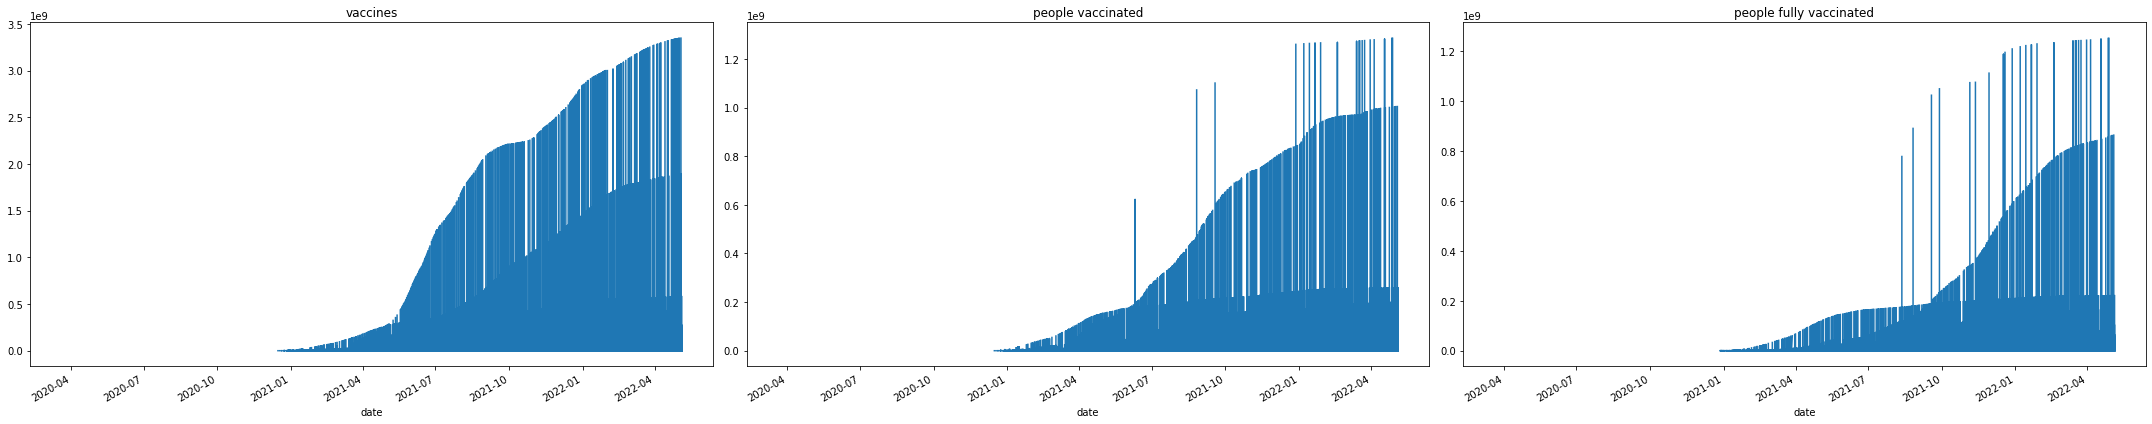

In [ ]:
plt.figure(figsize=(30,6))

plt.subplot(1, 3, 1)
plt.title('vaccines')
df.set_index('date')['vaccines'].plot()
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.title('people vaccinated')
df.set_index('date')['people_vaccinated'].plot()
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.title('people fully vaccinated')
df.set_index('date')['people_fully_vaccinated'].plot()
plt.tight_layout()

W kolumnach dotyczących szczepień najwięcej braków wynika z faktu wprowadzenia szczepionek do użytku ponad rok po rozpoczęciu pandemii- takie braki są widoczne w okresie 04.2020-01.2021. Braki danych do stycznia 2021 uzupełniam wartością 0, a do uzupełnienia braków danych z drugiej połowy pandemii wykorzystuję interpolacją.

In [ ]:
daterange = pd.date_range('20-03-2020', '10-01-2021')
for single_date in daterange:
  df.loc[df['date']==single_date, 'people_fully_vaccinated']=df.loc[df['date']==single_date, 'people_fully_vaccinated'].fillna(float(0))
  df.loc[df['date']==single_date, 'people_vaccinated']=df.loc[df['date']==single_date, 'people_vaccinated'].fillna(float(0))
  df.loc[df['date']==single_date, 'vaccines']=df.loc[df['date']==single_date, 'vaccines'].fillna(float(0))
 

In [ ]:
for x in df['iso_alpha_3'].unique():
  df.loc[df['iso_alpha_3']==x, 'vaccines']=df.loc[df['iso_alpha_3']==x, 'vaccines'].interpolate(limit_direction="both")
  df.loc[df['iso_alpha_3']==x, 'people_vaccinated']=df.loc[df['iso_alpha_3']==x, 'people_vaccinated'].interpolate(limit_direction="both")
  df.loc[df['iso_alpha_3']==x, 'people_fully_vaccinated']=df.loc[df['iso_alpha_3']==x, 'people_fully_vaccinated'].interpolate(limit_direction="both")

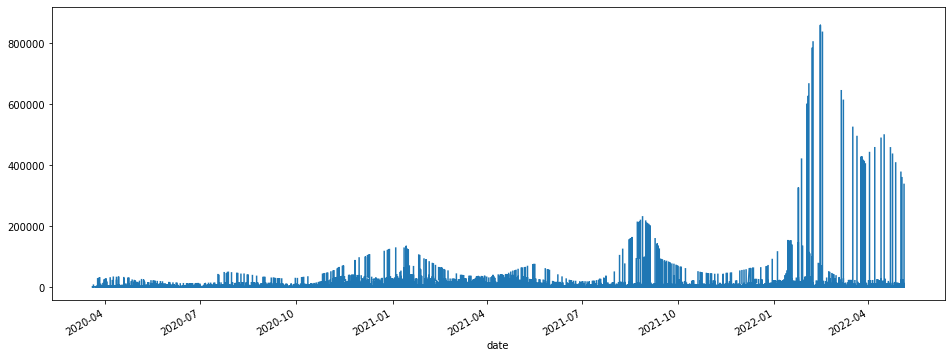

In [ ]:
df.set_index('date')['hosp'].plot(figsize = (16,6))

Braki danych dotyczące osób hospitalizowanych wynoszą ok 81%. Najpierw staram się wypełnić je używając intermolacji i metody ffill().Uzupełniją ona nie wielką ilość braków.Pozostałe braki wypełniam liczbą 0.

In [ ]:
for x in df['iso_alpha_3'].unique():
  df.loc[df['iso_alpha_3']==x, 'hosp']=df.loc[df['iso_alpha_3']==x, 'hosp'].interpolate(limit_direction="both")

In [ ]:
df['hosp']=df['hosp'].ffill()

In [ ]:
df['hosp']=df['hosp'].fillna(0)

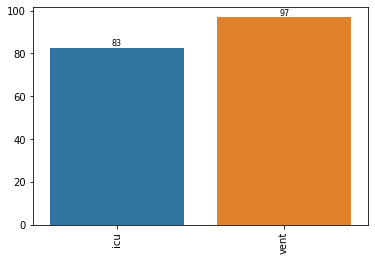

In [ ]:
nan_plot(df)

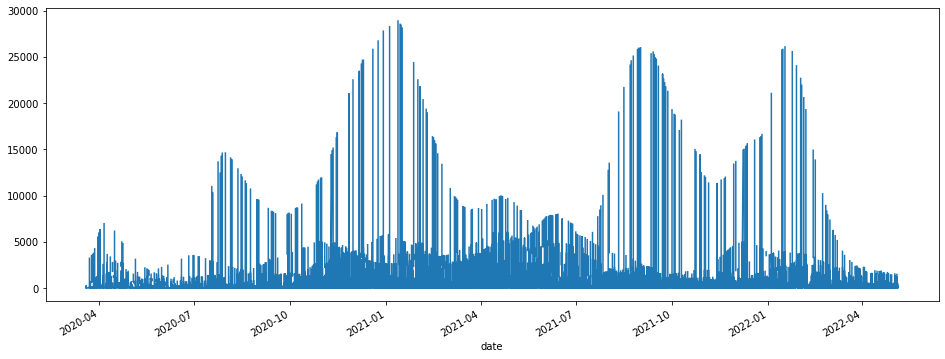

In [ ]:
df.set_index('date')['icu'].plot(figsize = (16,6))

In [ ]:
for x in df['iso_alpha_3'].unique():
  df.loc[df['iso_alpha_3']==x, 'icu']=df.loc[df['iso_alpha_3']==x, 'icu'].interpolate(limit_direction="both")

In [ ]:
df['icu']=df['icu'].fillna(0)

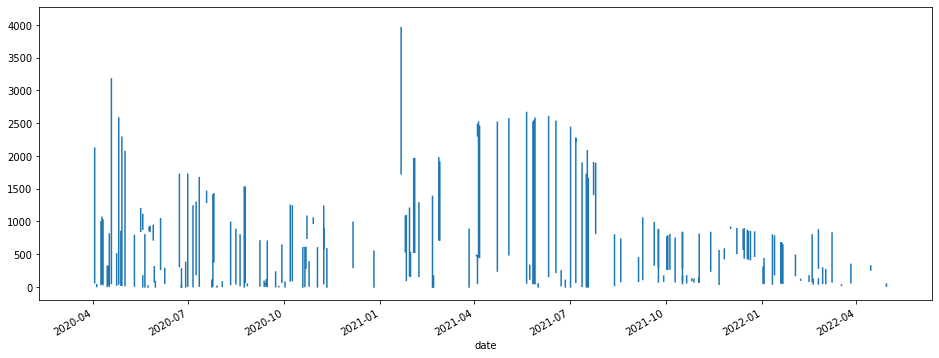

In [ ]:
df.set_index('date')['vent'].plot(figsize = (16,6))

In [ ]:
df['vent']=df['vent'].ffill()

In [ ]:
df['vent']=df['vent'].fillna(0)

In [ ]:
df=df.drop('iso_alpha_3', axis=1)

Grupuję dane po dacie i sumuję liczbe przpadków według daty

In [ ]:
df=df.groupby(['date']).sum().reset_index()

In [ ]:
df

,date,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,hosp,icu,vent
0,2020-03-20,284932.0,90755.0,2.250180e+06,3.837010e+08,0.000000e+00,0.000000e+00,0.000000e+00,1.107906e+06,17546.000000,28279.0
1,2020-03-21,317906.0,92503.0,2.256412e+06,3.839237e+08,0.000000e+00,0.000000e+00,0.000000e+00,1.112791e+06,18196.000000,29239.0
2,2020-03-22,351026.0,94268.0,2.260674e+06,3.845219e+08,0.000000e+00,0.000000e+00,0.000000e+00,1.126964e+06,18744.500000,29801.0
3,2020-03-23,393302.0,96247.0,2.267209e+06,3.849244e+08,0.000000e+00,0.000000e+00,0.000000e+00,1.140425e+06,19647.571429,29843.0
4,2020-03-24,435635.0,98543.0,2.275530e+06,3.984125e+08,0.000000e+00,0.000000e+00,0.000000e+00,1.154138e+06,20814.642857,30841.0
...,...,...,...,...,...,...,...,...,...,...,...
772,2022-05-01,498073649.0,5906200.0,2.226421e+08,1.518917e+10,1.140497e+10,5.052864e+09,4.582845e+09,1.678974e+06,9822.333333,33676.0
773,2022-05-02,498536048.0,5907895.0,2.227453e+08,1.519205e+10,1.140952e+10,5.053441e+09,4.584181e+09,1.664083e+06,9854.000000,33672.0
774,2022-05-03,503059890.0,5932801.0,2.257623e+08,1.523713e+10,1.143759e+10,5.063832e+09,4.595323e+09,1.647124e+06,9808.000000,33692.0
775,2022-05-04,499947018.0,5913606.0,2.229885e+08,1.519836e+10,1.141903e+10,5.054754e+09,4.587019e+09,1.635013e+06,9643.000000,33628.0


Do dalszej części projektu lepiej sprawdzą się dane z przyrostem dziennym, dlatego zamieniam dane kumulatywne na dzienne.Przy danych kumulacyjnych wyniki R2 każdego z algorytmów były wysokie, żadne z założeń regresji liniowej nie były spełniane, pozostając przy zmiennych kumulacyjnych dobranie zmiennych do regresji wielorakiej byłoby problematyczne- zmienne między sobą miały korelację bliską 100%. Pozostanie przy zmiennych skumulowanych uniemożliwiłoby efektywną realizację celu projektu

In [ ]:
for x in ['confirmed','deaths','recovered','tests','vaccines','people_vaccinated','people_fully_vaccinated']:
  df[x]=df[x]-df[x].shift(1,fill_value=0)

Przejście z danych kumulatywnych na dzienne spowodowało pojawienie się wartości ujemnych w niektórych komórkach, dlatego takie wartości z powrotem zamieniam na NaN i uzupełniam stosując interpolację

In [ ]:
df[['confirmed','deaths','recovered','tests']]= df[['confirmed','deaths','recovered','tests']].mask(df[['confirmed','deaths','recovered','tests']] <= 0)
df[['vaccines','people_vaccinated','people_fully_vaccinated']]= df[['vaccines','people_vaccinated','people_fully_vaccinated']].mask(df[['vaccines','people_vaccinated','people_fully_vaccinated']] <0)

In [ ]:
percent_missing(df)

tests                       1.415701
recovered                   1.544402
confirmed                   1.673102
deaths                      1.930502
people_fully_vaccinated    11.325611
vaccines                   12.355212
people_vaccinated          12.355212
dtype: float64

In [ ]:
for x in percent_missing(df).index.tolist():
  df[x]=df[x].interpolate(limit_direction="both")


In [ ]:
percent_missing(df)

Series([], dtype: float64)

Wykonując interpolację pojawiły się wartości po przecinku, aby się tego pozbyć wykonuję zaokrągenie na całej ramce danych

In [ ]:
df=df.round()



---
PODSTAWOWA EKSPLORACJA DANYCH


---




In [ ]:
df.head(5)

,date,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,hosp,icu,vent
0,2020-03-20,284932.0,90755.0,2250180.0,383701042.0,0.0,0.0,0.0,1107906.0,17546.0,28279.0
1,2020-03-21,32974.0,1748.0,6232.0,222655.0,0.0,0.0,0.0,1112791.0,18196.0,29239.0
2,2020-03-22,33120.0,1765.0,4262.0,598187.0,0.0,0.0,0.0,1126964.0,18744.0,29801.0
3,2020-03-23,42276.0,1979.0,6535.0,402506.0,0.0,0.0,0.0,1140425.0,19648.0,29843.0
4,2020-03-24,42333.0,2296.0,8321.0,13488142.0,0.0,0.0,0.0,1154138.0,20815.0,30841.0


In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     777 non-null    datetime64[ns]
 1   confirmed                777 non-null    float64       
 2   deaths                   777 non-null    float64       
 3   recovered                777 non-null    float64       
 4   tests                    777 non-null    float64       
 5   vaccines                 777 non-null    float64       
 6   people_vaccinated        777 non-null    float64       
 7   people_fully_vaccinated  777 non-null    float64       
 8   hosp                     777 non-null    float64       
 9   icu                      777 non-null    float64       
 10  vent                     777 non-null    float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 66.9 KB


,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,hosp,icu,vent
count,7.770000e+02,777.00000,7.770000e+02,7.770000e+02,7.770000e+02,7.770000e+02,7.770000e+02,7.770000e+02,777.000000,777.000000
mean,7.246665e+05,8737.79408,3.503957e+05,2.040328e+07,3.530221e+07,3.044384e+07,2.478715e+07,1.421385e+06,33970.902188,37193.101673
std,8.278028e+05,9230.25996,1.262920e+06,1.772112e+07,7.569816e+07,1.063700e+08,1.062668e+08,2.392079e+05,12858.575197,2143.771862
min,2.014900e+04,884.00000,4.262000e+03,2.226550e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.107906e+06,9527.000000,28279.000000
25%,3.010130e+05,5471.00000,8.926000e+04,1.909235e+07,1.400000e+01,7.000000e+00,1.000000e+00,1.239685e+06,23003.000000,36149.000000
50%,5.022830e+05,7801.00000,2.218040e+05,2.229439e+07,1.214184e+07,3.261921e+06,2.869068e+06,1.376416e+06,32285.000000,36832.000000
75%,7.031630e+05,10284.00000,3.423310e+05,2.434166e+07,3.305788e+07,1.310750e+07,1.222352e+07,1.481811e+06,44475.000000,38536.000000
max,5.355148e+06,199292.00000,3.319719e+07,3.837010e+08,5.639969e+08,1.169657e+09,1.013331e+09,2.319884e+06,61943.000000,41696.000000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


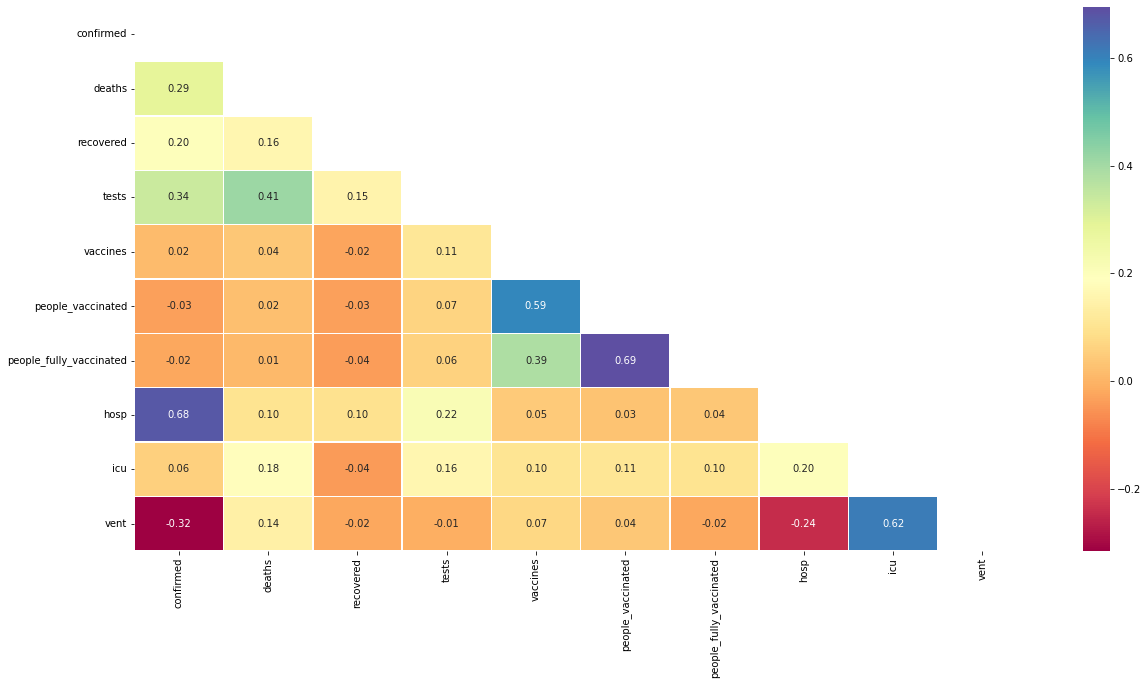

In [ ]:
corr_df =  df.corr() 
mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool)
fig, ax = plt.subplots( figsize=(20,10) )
sns.heatmap(corr_df, mask=mask_ut,annot=True, linewidths=.5, fmt='.2f',ax=ax, cmap="Spectral")



---
STANDARYZACJA DANYCH


---




In [ ]:
date=df.copy()
df=df.drop('date',axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler.fit(df)
scaled_features = scaler.transform(df)
df = pd.DataFrame(scaled_features,columns=df.columns)



---
##**GLOBALNA PREDYKCJA LICZBY ZACHOROWAŃ**


---






---
PODZIAŁ DANYCH


---




In [ ]:
X=df[['deaths', 'recovered', 'tests', 'vaccines','people_vaccinated', 'people_fully_vaccinated', 'hosp', 'icu','vent']]
Y=df['confirmed']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.30,random_state=5)



---
REGRESJA LINIOWA


---




In [ ]:
corr_df.sort_values('confirmed', ascending = False)['confirmed']

confirmed                  1.000000
hosp                       0.675597
tests                      0.338717
deaths                     0.285748
recovered                  0.198295
icu                        0.056127
vaccines                   0.015934
people_fully_vaccinated   -0.020728
people_vaccinated         -0.034758
vent                      -0.315516
Name: confirmed, dtype: float64

In [ ]:
data_frame1=pd.DataFrame(columns=["R2 score", "RMSE","MAE", "MSE"])

In [ ]:
for x in ['deaths', 'recovered', 'tests', 'vaccines','people_vaccinated', 'people_fully_vaccinated', 'hosp', 'icu','vent']:
  LR=LinearRegression()

  LR.fit(X_train[x].values.reshape(-1, 1),y_train)
  pred=LR.predict(X_test[x].values.reshape(-1,1))

  df2 = pd.DataFrame({"R2 score":metrics.r2_score(y_test, pred).round(4),
                                  "RMSE": np.sqrt(metrics.mean_squared_error(y_test, pred)).round(4),
                                  "MAE":metrics.mean_absolute_error(y_test, pred).round(4),
                                  "MSE": metrics.mean_squared_error(y_test, pred).round(4)}, index ={x})
  data_frame1=data_frame1.append(df2)

In [ ]:
data_frame1.sort_values(by="R2 score",ascending=False)

,R2 score,RMSE,MAE,MSE
hosp,0.4126,0.7928,0.4019,0.6285
tests,0.1475,0.9550,0.5667,0.9121
vent,0.1277,0.9661,0.5828,0.9333
recovered,0.0567,1.0046,0.5923,1.0092
deaths,0.0101,1.0291,0.6007,1.0591
people_vaccinated,-0.0017,1.0352,0.6091,1.0716
people_fully_vaccinated,-0.0030,1.0359,0.6095,1.0731
vaccines,-0.0067,1.0378,0.6141,1.0770
icu,-0.0305,1.0500,0.6181,1.1025


Najlepsze rezultaty dla regresji liniowej uzyskałam zmienną 'hosp'-i to dla niej będę sprawdzała założenia regresji liniowej



---


SPRAWDZENIE ZAŁOŻEŃ REGRESJI LINIOWEJ


---






In [ ]:
LR=LinearRegression()

LR.fit(X_train['hosp'].values.reshape(-1,1),y_train)
pred_1=LR.predict(X_test['hosp'].values.reshape(-1,1))

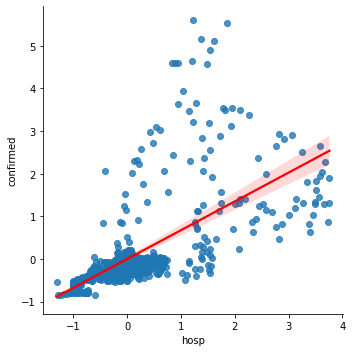

In [ ]:
sns.lmplot(x='hosp',y='confirmed',data=df,line_kws={'color': 'red'})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-2.0, 2.0)

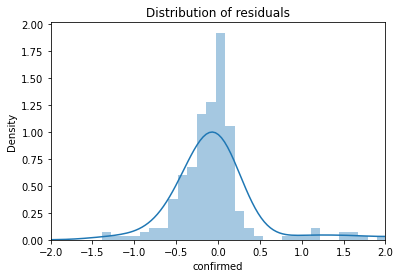

In [ ]:
residuals = y_test-pred_1

sns.distplot(residuals,kde=True)
plt.title('Distribution of residuals')
plt.xlim(-2,2)

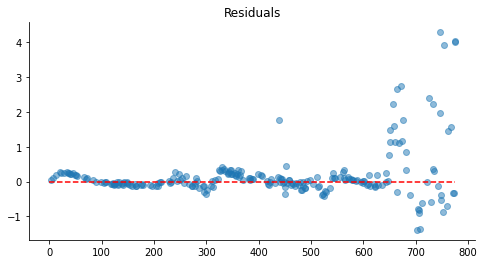

In [ ]:
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': pred_1})
df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])  
plt.subplots(figsize=(8, 4))
ax = plt.subplot(111)  
plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
plt.plot(np.repeat(0, df_results.index.max()), color='red', linestyle='--')

ax.spines['right'].set_visible(False)  
ax.spines['top'].set_visible(False)  
plt.title('Residuals')
plt.show() 

Nie wszystkie założenia regresji liniowej zostały spełnione-nie ma liniowej zależności pomiędzy zmienną objaśniającą a objaśnianą, natomiast rozkłąd błędów przypomina rozkład normalny a rezydua są równo rozproszone.



---
REGRESJA WIELOWYMIAROWA


---




/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


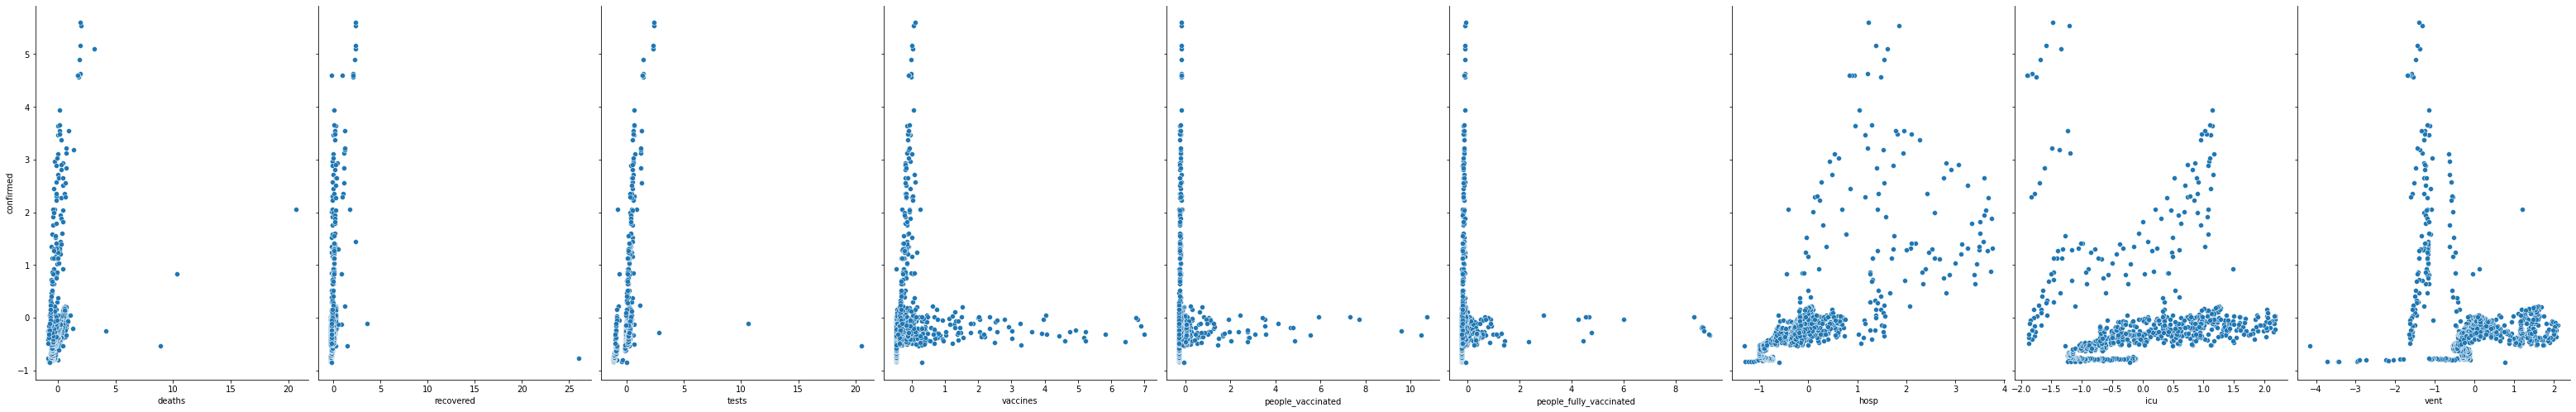

In [ ]:
sns.pairplot(df,x_vars=['deaths', 'recovered', 'tests', 'vaccines','people_vaccinated', 'people_fully_vaccinated', 'hosp', 'icu','vent'],
             y_vars=['confirmed'],size=7,aspect=0.7)

**Wybór parametrów do regresji wielorakiej:**



Żadna ze zmiennych nie wykazuje liniowej zależności ze zmienną 'confirmed', dlatego dobieram parametry na podstawie korelacji.Do modelu regresji liniowej wybieram zmienne które wykazują największą korelację ze zmienną 'confirmed': 'hosp','tests','deaths' 

In [ ]:
LR2=LinearRegression()

model=LR2.fit(X_train[['hosp','tests','deaths']],y_train)
predicted_1=model.predict(X_test[['hosp','tests','deaths']])

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, predicted_1))
print('MSE:', metrics.mean_squared_error(y_test, predicted_1))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted_1)))
print('R2 score:', metrics.r2_score(y_test, predicted_1))

print(f"Test score: {metrics.r2_score(y_test, predicted_1)*100:.2f}%")

MAE: 0.40048773391480597
MSE: 0.5488941608339625
RMSE: 0.7408739169615586
R2 score: 0.4869355558115309
Test score: 48.69%




---

REGRESJA LINIOWA VS WIELORAKA - PORÓWNANIE

---



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

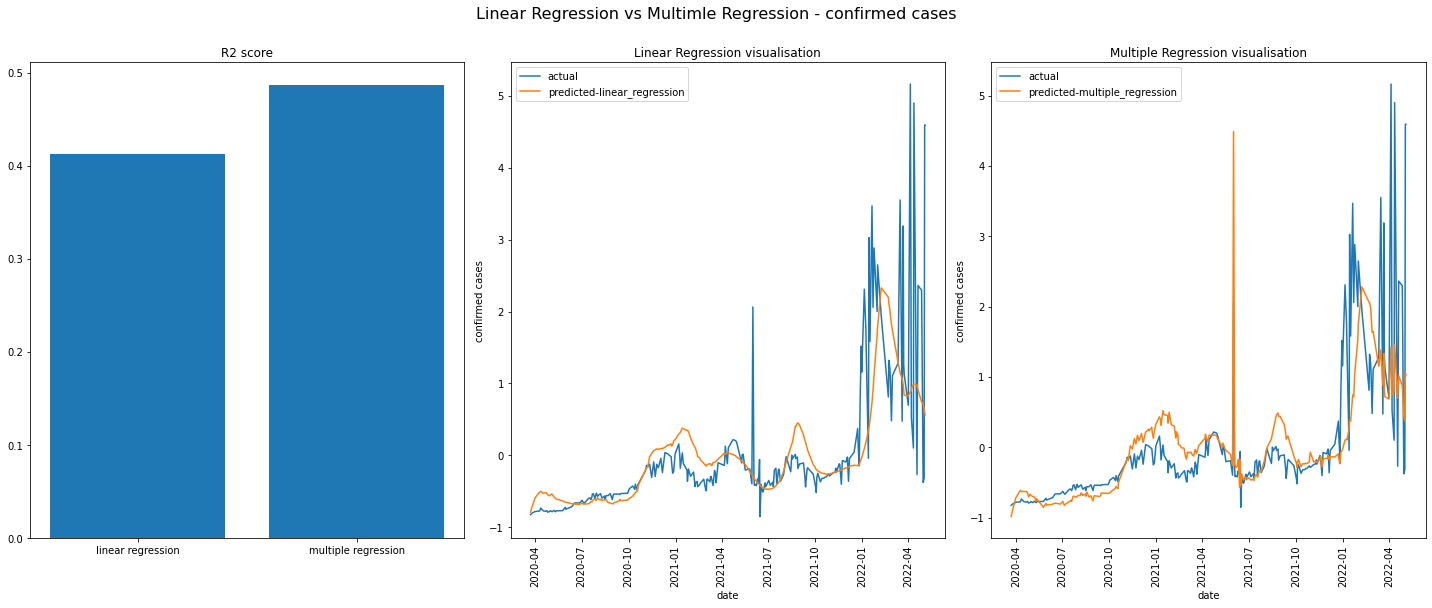

In [ ]:
plt.figure(figsize=(20,8))
plt.suptitle('Linear Regression vs Multimle Regression - confirmed cases', fontsize=16,y=1.05)

plt.subplot(1,3,1)
plt.title('R2 score')
l = ['linear regression','multiple regression']
r2 = [metrics.r2_score(y_test, pred_1).round(4) , metrics.r2_score(y_test, predicted_1).round(4)]
plt.bar(l,r2)

plt.subplot(1, 3, 2)
plt.title('Linear Regression visualisation')
sns.lineplot(date['date'].iloc[X_test.index].values,y_test)
sns.lineplot(date['date'].iloc[X_test.index].values,pred_1)
plt.legend(labels=["actual","predicted-linear_regression"])

plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('confirmed cases')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.title('Multiple Regression visualisation')
sns.lineplot(date['date'].iloc[X_test.index].values,y_test)
sns.lineplot(date['date'].iloc[X_test.index].values,predicted_1)
plt.legend(labels=["actual","predicted-multiple_regression"])

plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('confirmed cases')
plt.tight_layout()

Wyniki zarówno regresji liniowej jak i wielorakiej nie są zadowalające. Lepiej wypada regresja wieloraka r2-ok.50%, liniowa-ok.40%. Takie wyniki w żadnym przypadku nie pozwalają na przeprowadzenie dokładnej predykcji liczby zachorowań-predykcja wykonana na podstawie algorytmów opartych na regresji jest daleka od wartości oczekiwanych. Oba wykresy nie pokrywają się z aktualnymi wartościami , rozbieżność między wynikami jest duża



---


DZIAŁANIE ALGORYTMÓW:SVR, DRZEW REGRESYJNYCH,LOSOWEGO LASU REGRESYJNEGO


---



In [ ]:
df_gc=pd.DataFrame(columns=["R2 score", "RMSE","MAE", "MSE"])

In [ ]:
from sklearn.svm import SVR
SVR = SVR()

model=SVR.fit(X_train[['hosp','tests','deaths']],y_train)
predicted1=model.predict(X_test[['hosp','tests','deaths']])
df2 = pd.DataFrame({"R2 score":metrics.r2_score(y_test, predicted1).round(4),
                                  "RMSE": np.sqrt(metrics.mean_squared_error(y_test, predicted1)).round(4),
                                  "MAE":metrics.mean_absolute_error(y_test, predicted1).round(4),
                                  "MSE": metrics.mean_squared_error(y_test, predicted1).round(4)}, index ={'SVR'})
df_gc=df_gc.append(df2)

In [ ]:
tree_reg =  DecisionTreeRegressor()

model=tree_reg.fit(X_train[['hosp','tests','deaths']],y_train)
predicted2=model.predict(X_test[['hosp','tests','deaths']])
df2 = pd.DataFrame({"R2 score":metrics.r2_score(y_test, predicted2).round(4),
                                  "RMSE": np.sqrt(metrics.mean_squared_error(y_test, predicted2)).round(4),
                                  "MAE":metrics.mean_absolute_error(y_test, predicted2).round(4),
                                  "MSE": metrics.mean_squared_error(y_test, predicted2).round(4)}, index ={'Decision Tree Regressor'})
df_gc=df_gc.append(df2)

In [ ]:
forest_reg = RandomForestRegressor()

model=forest_reg.fit(X_train[['hosp','tests','deaths']],y_train)
predicted3=model.predict(X_test[['hosp','tests','deaths']])
df2 = pd.DataFrame({"R2 score":metrics.r2_score(y_test, predicted3).round(4),
                                  "RMSE": np.sqrt(metrics.mean_squared_error(y_test, predicted3)).round(4),
                                  "MAE":metrics.mean_absolute_error(y_test, predicted3).round(4),
                                  "MSE": metrics.mean_squared_error(y_test, predicted3).round(4)}, index ={'Random Forest Regressor'})
df_gc=df_gc.append(df2)

In [ ]:
df_gc.sort_values(by="R2 score",ascending=False)

,R2 score,RMSE,MAE,MSE
Random Forest Regressor,0.9118,0.3072,0.1348,0.0943
Decision Tree Regressor,0.8670,0.3772,0.1694,0.1423
SVR,0.8372,0.4173,0.2195,0.1741


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

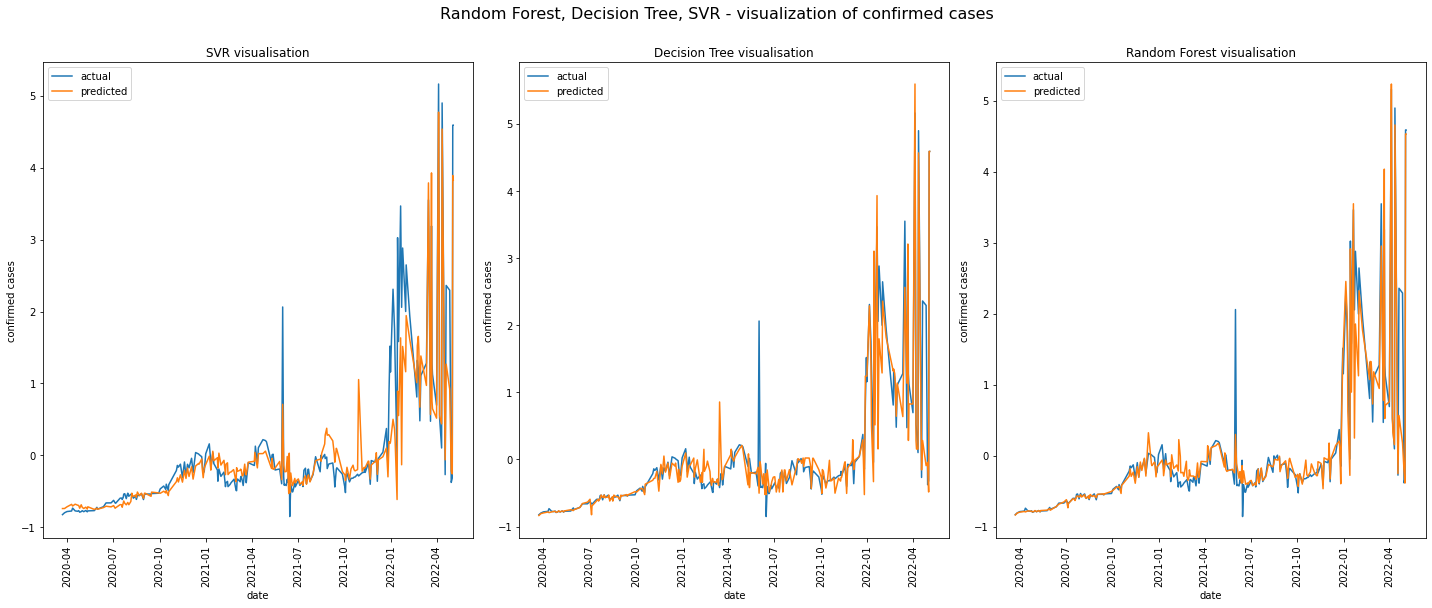

In [ ]:
plt.figure(figsize=(20,8))
plt.suptitle('Random Forest, Decision Tree, SVR - visualization of confirmed cases', fontsize=16,y=1.05)

plt.subplot(1, 3, 1)
plt.title('SVR visualisation')
sns.lineplot(date['date'].iloc[X_test.index].values,y_test)
sns.lineplot(date['date'].iloc[X_test.index].values,predicted1)
plt.legend(labels=["actual","predicted"])

plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('confirmed cases')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.title('Decision Tree visualisation')
sns.lineplot(date['date'].iloc[X_test.index].values,y_test)
sns.lineplot(date['date'].iloc[X_test.index].values,predicted2)
plt.legend(labels=["actual","predicted"])

plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('confirmed cases')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.title('Random Forest visualisation')
sns.lineplot(date['date'].iloc[X_test.index].values,y_test)
sns.lineplot(date['date'].iloc[X_test.index].values,predicted3)
plt.legend(labels=["actual","predicted"])

plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('confirmed cases')
plt.tight_layout()

Wszystkie powyższe algorytmy dały bardzo dobre rezultaty, najlepiej z predykcją zachorowań poradził sobie Random Forest. Różnice pomiędzy  wizualizacjami są niewielkie- jednyne różnice które zauważam na pierwszy rzut oka pomiędzy Random Forest a pozostałymi to - wartości odstające w SVR 09.2021 i Decision Tree 04.2021



---
##**GLOBALNA PREDYKCJA ŚMIERCI SPOWODOWANEJ PRZEZ COVID-19**


---






---


PODZIAŁ DANYCH


---



In [ ]:
X=df[['confirmed', 'recovered', 'tests', 'vaccines','people_vaccinated', 'people_fully_vaccinated', 'hosp', 'icu','vent']]
Y=df['deaths']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.30, random_state=40)



---


REGRESJA LINIOWA


---



In [ ]:
corr_df.sort_values('deaths', ascending = False)['deaths']

deaths                     1.000000
tests                      0.413057
confirmed                  0.285748
icu                        0.182616
recovered                  0.159893
vent                       0.140193
hosp                       0.101765
vaccines                   0.039431
people_vaccinated          0.020658
people_fully_vaccinated    0.011436
Name: deaths, dtype: float64

In [ ]:
data_frame2=pd.DataFrame(columns=["R2 score", "RMSE","MAE", "MSE"])

In [ ]:
for x in ['confirmed', 'recovered', 'tests', 'vaccines','people_vaccinated', 'people_fully_vaccinated', 'hosp', 'icu','vent']:
  LR=LinearRegression()

  LR.fit(X_train[x].values.reshape(-1, 1),y_train)
  pred=LR.predict(X_test[x].values.reshape(-1,1))

  df2 = pd.DataFrame({"R2 score":metrics.r2_score(y_test, pred).round(4),
                                  "RMSE": np.sqrt(metrics.mean_squared_error(y_test, pred)).round(4),
                                  "MAE":metrics.mean_absolute_error(y_test, pred).round(4),
                                  "MSE": metrics.mean_squared_error(y_test, pred).round(4)}, index ={x})
  data_frame2=data_frame2.append(df2)


In [ ]:
data_frame2.sort_values(by="R2 score",ascending=False)

,R2 score,RMSE,MAE,MSE
tests,0.7502,0.3628,0.2747,0.1316
recovered,0.0672,0.7011,0.3495,0.4915
icu,0.0360,0.7127,0.2860,0.5079
confirmed,0.0154,0.7203,0.3408,0.5188
hosp,0.0121,0.7215,0.3446,0.5205
people_vaccinated,0.0010,0.7255,0.3644,0.5264
people_fully_vaccinated,-0.0007,0.7261,0.3656,0.5273
vaccines,-0.0013,0.7264,0.3652,0.5276
vent,-0.0873,0.7569,0.3230,0.5729




---


SPRAWDZENIE ZAŁOŻEŃ REGRESJI LINIOWEJ


---



Najlepszą rezultaty regresji liniowej w globalnej predykcji śmierci uzyskałam zmienną 'tests'-i to dla niej będę sprawdzała założenia regresji liniowej

In [ ]:
LR=LinearRegression()

LR.fit(X_train['tests'].values.reshape(-1,1),y_train)
pred_2=LR.predict(X_test['tests'].values.reshape(-1,1))

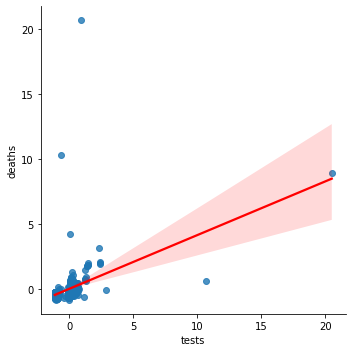

In [ ]:
sns.lmplot(x='tests',y='deaths',data=df,line_kws={'color': 'red'})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-3.0, 3.0)

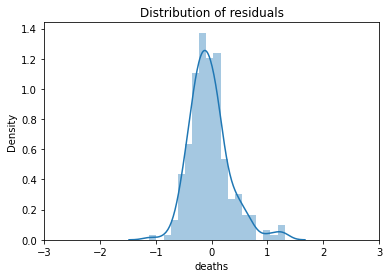

In [ ]:
residuals = y_test-pred_2
sns.distplot(residuals,kde=True)
plt.title('Distribution of residuals')
plt.xlim([-3,3])

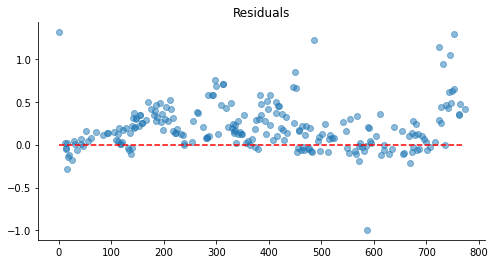

In [ ]:
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': pred_2})
df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])  
plt.subplots(figsize=(8, 4))
ax = plt.subplot(111)  
plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
plt.plot(np.repeat(0, df_results.index.max()), color='red', linestyle='--')
ax.spines['right'].set_visible(False)  
ax.spines['top'].set_visible(False)  
plt.title('Residuals')
plt.show()

Spełnione zostało tylko jedne z zaałożeń regresji liniowej - rozkład błędów przypomina rozkłąd normalny. Założenia dotyczące współliniowości zmiennych i homoskedastyczności nie zostały spełnione. Nie widzę liniowej zależności na wykresie- punkty są skumulowane w jednym miejscu, a rezydua w większości znajduja się nad czerwoną linią.



---


REGRESJA WIELOMIANOWA


---



/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


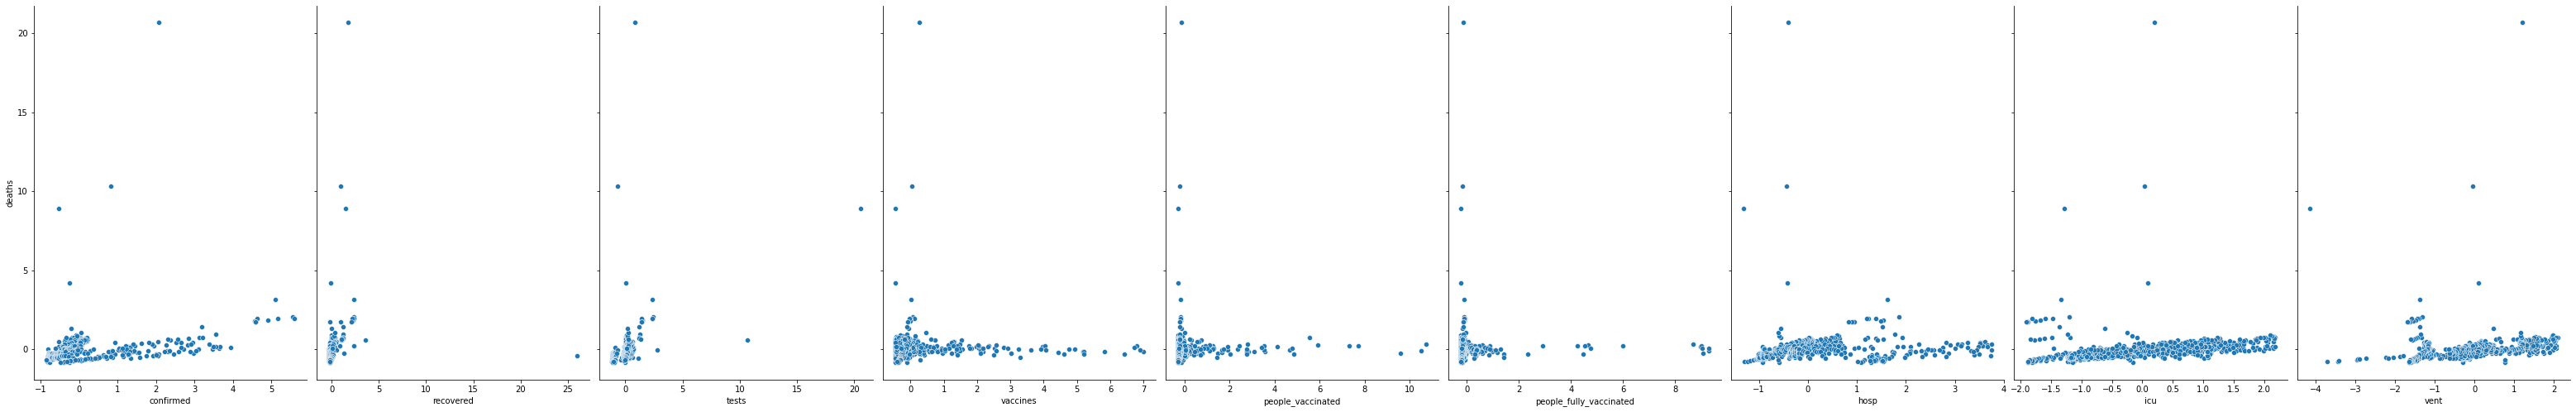

In [ ]:
sns.pairplot(df,x_vars=['confirmed', 'recovered', 'tests', 'vaccines','people_vaccinated', 'people_fully_vaccinated', 'hosp', 'icu','vent'],
             y_vars=['deaths'],size=7,aspect=0.7)

**Wybór parametrów do regresji wielorakiej:**

Zmienne do regresji wielorakiej dobiorę na podstawie korelacji i wyników regresji liniowej .Najlepiej skorelowane z 'death' są zmienne: 'confirmed', 'tests', 'icu', ale to 'recovered' dało w regresji liniowe lepsze rezultaty, dlatego zamiast 'confirmed' użyję zmiennej 'recovered'

In [ ]:
LR2=LinearRegression()

model=LR2.fit(X_train[['recovered','icu','tests']],y_train)
predicted_2=model.predict(X_test[['recovered','icu','tests']])
print('MAE:', metrics.mean_absolute_error(y_test, predicted_2))
print('MSE:', metrics.mean_squared_error(y_test, predicted_2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted_2)))
print('R2 score:', metrics.r2_score(y_test, predicted_2))

print(f"Test score: {metrics.r2_score(y_test, predicted_2)*100:.2f}%")


MAE: 0.22415267025673982
MSE: 0.13240634028836634
RMSE: 0.3638768202130583
R2 score: 0.7487162731289151
Test score: 74.87%




---
REGRESJA LINIOWA VS WIELORAKA - PORÓWNANIE


---




/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

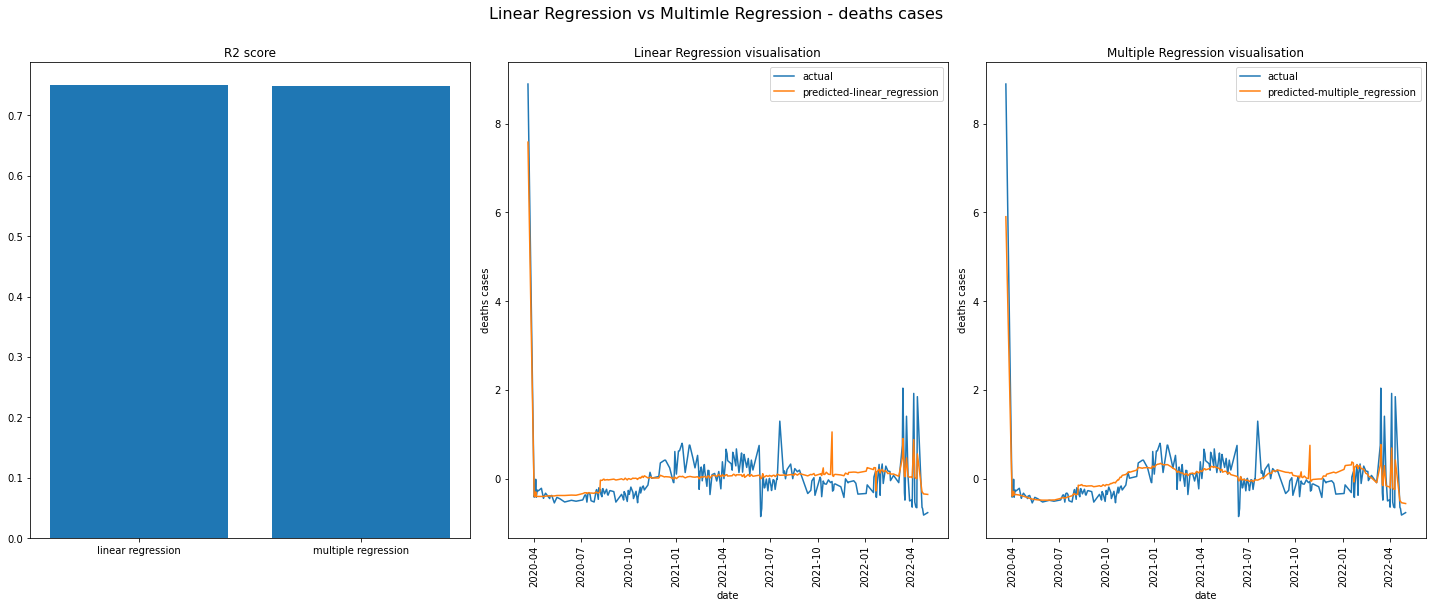

In [ ]:
plt.figure(figsize=(20,8))
plt.suptitle('Linear Regression vs Multimle Regression - deaths cases', fontsize=16,y=1.05)

plt.subplot(1,3,1)
plt.title('R2 score')
l = ['linear regression','multiple regression']
r2 = [metrics.r2_score(y_test, pred_2).round(4) , metrics.r2_score(y_test, predicted_2).round(4)]
plt.bar(l,r2)

plt.subplot(1, 3, 2)
plt.title('Linear Regression visualisation')
sns.lineplot(date['date'].iloc[X_test.index].values,y_test)
sns.lineplot(date['date'].iloc[X_test.index].values,pred_2)
plt.legend(labels=["actual","predicted-linear_regression"])

plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('deaths cases')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.title('Multiple Regression visualisation')
sns.lineplot(date['date'].iloc[X_test.index].values,y_test)
sns.lineplot(date['date'].iloc[X_test.index].values,predicted_2)
plt.legend(labels=["actual","predicted-multiple_regression"])

plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('deaths cases')
plt.tight_layout()

Predykcja śmierci dla danych globalnych również dała ciekawe wyniki, aczkolwiek nie satysfakcjonujące. Tutaj regresja liniowa była minimalnie lepsza- różnica ok.1 punkta procentowego, ale analizując wykresy łatwo stwierdzić, że to regresja wieloraka lepiej poradziła sobie z dopasowaniem wartości. Regresja liniowa nie poradziła sobie z nieliniowymi zależnościami. Wyniki regresji wielorakiej lepiej pokrywają się z danymi aktualnymi, ale nie jest to na tyle dobry wynik, aby uznać, że liczba śmierci została przewidziana poprawnie.



---


DZIAŁANIE ALGORYTMÓW:SVR, DRZEW REGRESYJNYCH,LOSOWEGO LASU REGRESYJNEGO


---



In [ ]:
df_gd=pd.DataFrame(columns=["R2 score", "RMSE","MAE", "MSE"])

In [ ]:
from sklearn.svm import SVR
SVR = SVR()

model=SVR.fit(X_train[['recovered','icu','tests']],y_train)
predicted11=model.predict(X_test[['recovered','icu','tests']])
df2 = pd.DataFrame({"R2 score":metrics.r2_score(y_test, predicted11).round(4),
                                  "RMSE": np.sqrt(metrics.mean_squared_error(y_test, predicted11)).round(4),
                                  "MAE":metrics.mean_absolute_error(y_test, predicted11).round(4),
                                  "MSE": metrics.mean_squared_error(y_test, predicted11).round(4)}, index ={'SVR'})

df_gd=df_gd.append(df2)

In [ ]:
tree_reg =  DecisionTreeRegressor()

model=tree_reg.fit(X_train[['recovered','icu','tests']],y_train)
predicted22=model.predict(X_test[['recovered','icu','tests']])
df2 = pd.DataFrame({"R2 score":metrics.r2_score(y_test, predicted22).round(4),
                                  "RMSE": np.sqrt(metrics.mean_squared_error(y_test, predicted22)).round(4),
                                  "MAE":metrics.mean_absolute_error(y_test, predicted22).round(4),
                                  "MSE": metrics.mean_squared_error(y_test, predicted22).round(4)}, index ={'Decision Tree Regressor'})
df_gd=df_gd.append(df2)

In [ ]:
forest_reg = RandomForestRegressor()

model=forest_reg.fit(X_train[['recovered','icu','tests']],y_train)
predicted33=model.predict(X_test[['recovered','icu','tests']])
df2 = pd.DataFrame({"R2 score":metrics.r2_score(y_test, predicted33).round(4),
                                  "RMSE": np.sqrt(metrics.mean_squared_error(y_test, predicted33)).round(4),
                                  "MAE":metrics.mean_absolute_error(y_test, predicted33).round(4),
                                  "MSE": metrics.mean_squared_error(y_test, predicted33).round(4)}, index ={'Random Forest Regressor'})
df_gd=df_gd.append(df2)

In [ ]:
df_gd.sort_values(by="R2 score",ascending=False)

,R2 score,RMSE,MAE,MSE
Random Forest Regressor,0.8396,0.2907,0.1483,0.0845
Decision Tree Regressor,0.5904,0.4646,0.1955,0.2158
SVR,0.3130,0.6017,0.1765,0.3620


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

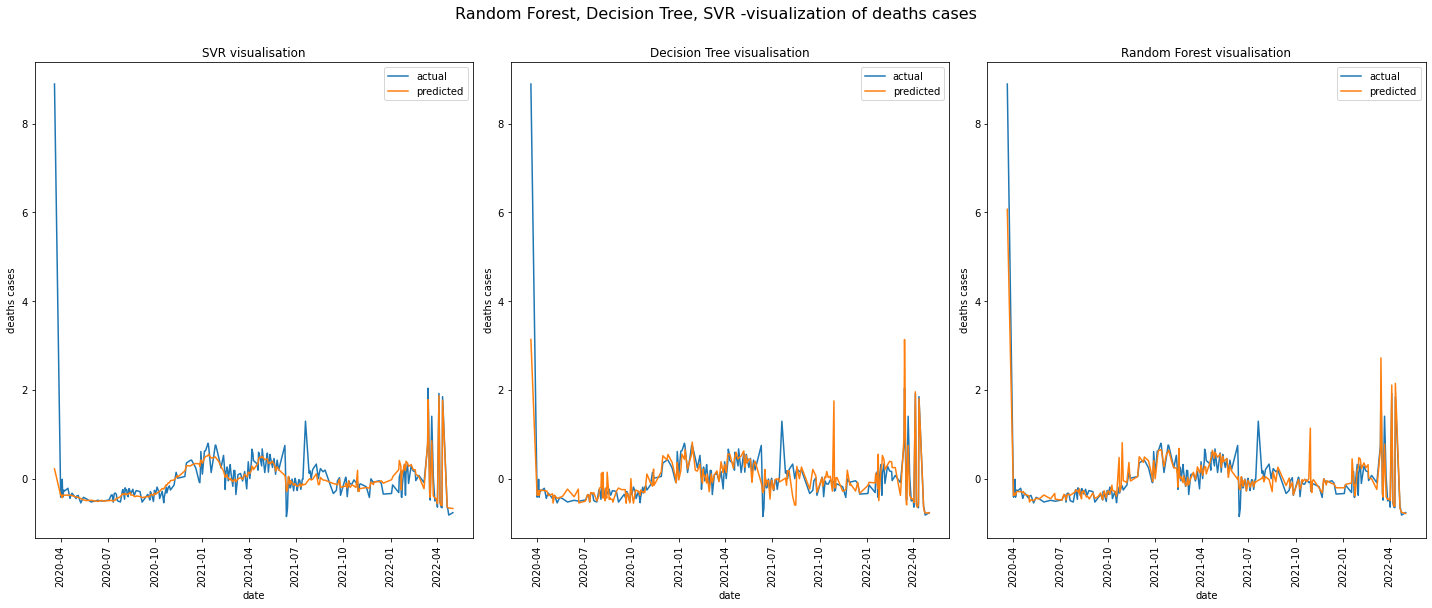

In [ ]:
plt.figure(figsize=(20,8))
plt.suptitle('Random Forest, Decision Tree, SVR -visualization of deaths cases', fontsize=16,y=1.05)

plt.subplot(1, 3, 1)
plt.title('SVR visualisation')
sns.lineplot(date['date'].iloc[X_test.index].values,y_test)
sns.lineplot(date['date'].iloc[X_test.index].values,predicted11)
plt.legend(labels=["actual","predicted"])

plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('deaths cases')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.title('Decision Tree visualisation')
sns.lineplot(date['date'].iloc[X_test.index].values,y_test)
sns.lineplot(date['date'].iloc[X_test.index].values,predicted22)
plt.legend(labels=["actual","predicted"])

plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('deaths cases')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.title('Random Forest visualisation')
sns.lineplot(date['date'].iloc[X_test.index].values,y_test)
sns.lineplot(date['date'].iloc[X_test.index].values,predicted33)
plt.legend(labels=["actual","predicted"])

plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('deaths cases')
plt.tight_layout()

Ponownie najlepiej poradził sobie Random Forest regressor. Równie dobre wyniki dał algorytm Decision Tree, w przeciwieństwie do Random Forest poradził sobie gorzej z predykcją wartości w czerwcu 2020 i wrześniu 2021- widać dosyć sporą rozbieżność od danych aktualnych. Najgorsze rezultaty r2 score uzyskałam algorytmem SVR, na wizualizacji również widać że jest bardzo wrażliwy na wartości odstające i nie był w stanie dopasować przewidywań do aktualnych wartości



---
#**DANE LOKALNE - DANIA**


---




In [ ]:
df3, src2 = covid19("Denmark")

We have invested a lot of time and effort in creating COVID-19 Data Hub, please cite the following when using it:

	Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.

A BibTeX entry for LaTeX users is

	@Article{,
		title = {COVID-19 Data Hub},
		year = {2020},
		doi = {10.21105/joss.02376},
		author = {Emanuele Guidotti and David Ardia},
		journal = {Journal of Open Source Software},
		volume = {5},
		number = {51},
		pages = {2376},
	}

To hide this message use 'verbose = False'.




---
UZUPEŁNIENIE BRAKUJĄCYCH WARTOŚCI


---




Tak jak w danych globalnych czyszczenie danych zaczynam od usunięcia kolumn niezwiązanych z chorobą. Zmienne kumulatywne uzupełniam korzystając z interpolacji.

In [ ]:
df3=df3.drop(['id','international_movement_restrictions', 'administrative_area_level','administrative_area_level_2','administrative_area_level_1','administrative_area_level_3',
                          'latitude', 'longitude','population', 'iso_alpha_3', 'iso_alpha_2','iso_numeric',
                          'iso_currency', 'key_local', 'key_google_mobility', 'key_apple_mobility', 'key_jhu_csse', 'key_nuts', 'key_gadm'], axis=1)

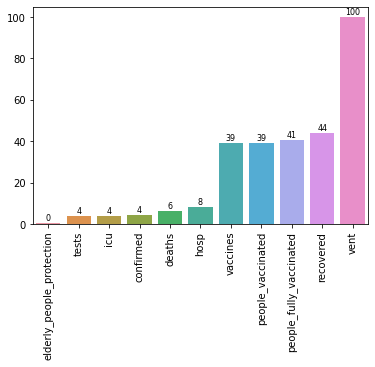

In [ ]:
nan_plot(df3)


W kolumnach w których wartości NaN stanowią mniej niż 5 % uznaję za całkowicie losowe i usuwam wiersze z tymi wartościami

In [ ]:
percent_nan=percent_missing(df3)
df3=df3.dropna(axis=0,subset=percent_nan[percent_nan<5].index)

Kolumnę 'vent' usuwam, ponieważ ilość braków danych wynosi 100%

In [ ]:
df3=df3.drop('vent', axis=1)

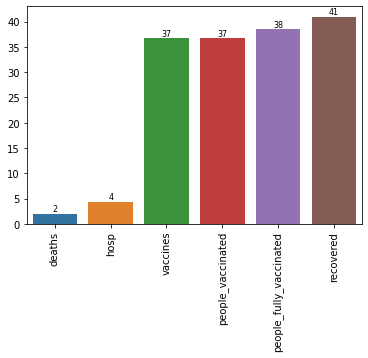

In [ ]:
nan_plot(df3)

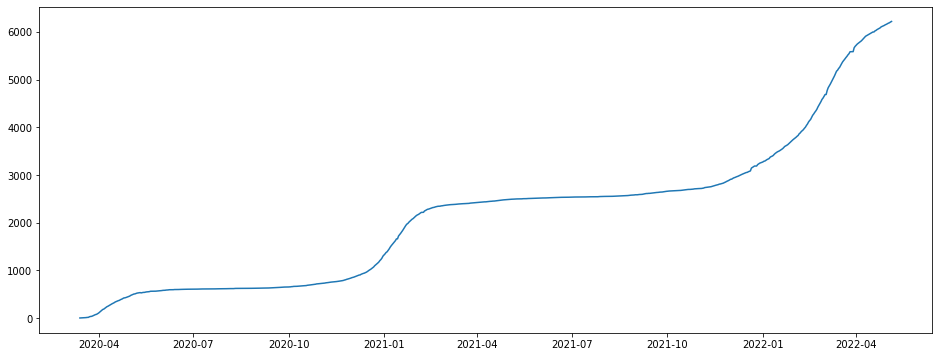

In [ ]:
fig, ax = plt.subplots(figsize = (16,6))
ax.plot(df3.set_index('date')['deaths'])
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [ ]:
df3['deaths']=df3['deaths'].interpolate(limit_direction="both")

In [ ]:
df3['deaths']=df3['deaths'].round()

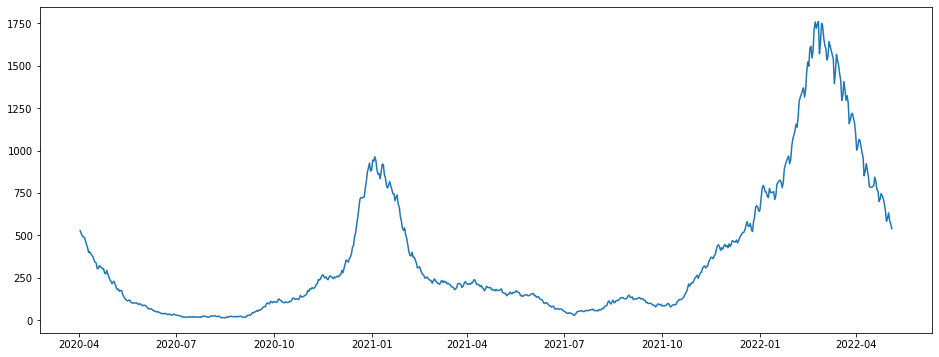

In [ ]:
fig, ax = plt.subplots(figsize = (16,6))
ax.plot(df3.set_index('date')['hosp'])
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [ ]:
df2=df3[df3['hosp'].isnull()]['date']
df2

156302   2020-02-27
156303   2020-02-28
156304   2020-02-29
156305   2020-03-01
156306   2020-03-02
156307   2020-03-03
156308   2020-03-04
156309   2020-03-05
156310   2020-03-06
156311   2020-03-07
156312   2020-03-08
156313   2020-03-09
156314   2020-03-10
156315   2020-03-11
156316   2020-03-12
156317   2020-03-13
156318   2020-03-14
156319   2020-03-15
156320   2020-03-16
156321   2020-03-17
156322   2020-03-18
156323   2020-03-19
156324   2020-03-20
156325   2020-03-21
156326   2020-03-22
156327   2020-03-23
156328   2020-03-24
156329   2020-03-25
156330   2020-03-26
156331   2020-03-27
156332   2020-03-28
156333   2020-03-29
156334   2020-03-30
156335   2020-03-31
156336   2020-04-01
Name: date, dtype: datetime64[ns]

Braki danych w kolumnie 'hosp' są z pierwzsego miesiąca pandemii, gdzie teoretycznie liczba przypadków hospitalizowanych powinna być najmniejsza. Te braki uzupełnię medianą,ponieważ nie jest ona tak podatna na wartości odstające jak średnia a w tych danych mamy sporo okresów spadku jak i wzrostu osoób przebywających w szpitalu, więc najlepiej w tej sytuacji poradzi sobie mediana

In [ ]:
df3['hosp']=df3['hosp'].fillna(int(df3['hosp'].median()))

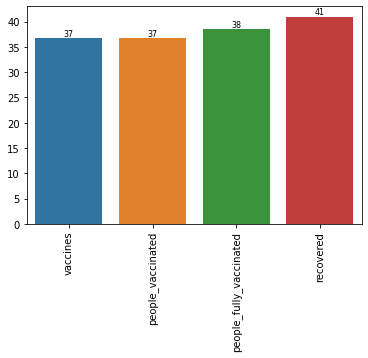

In [ ]:
nan_plot(df3)

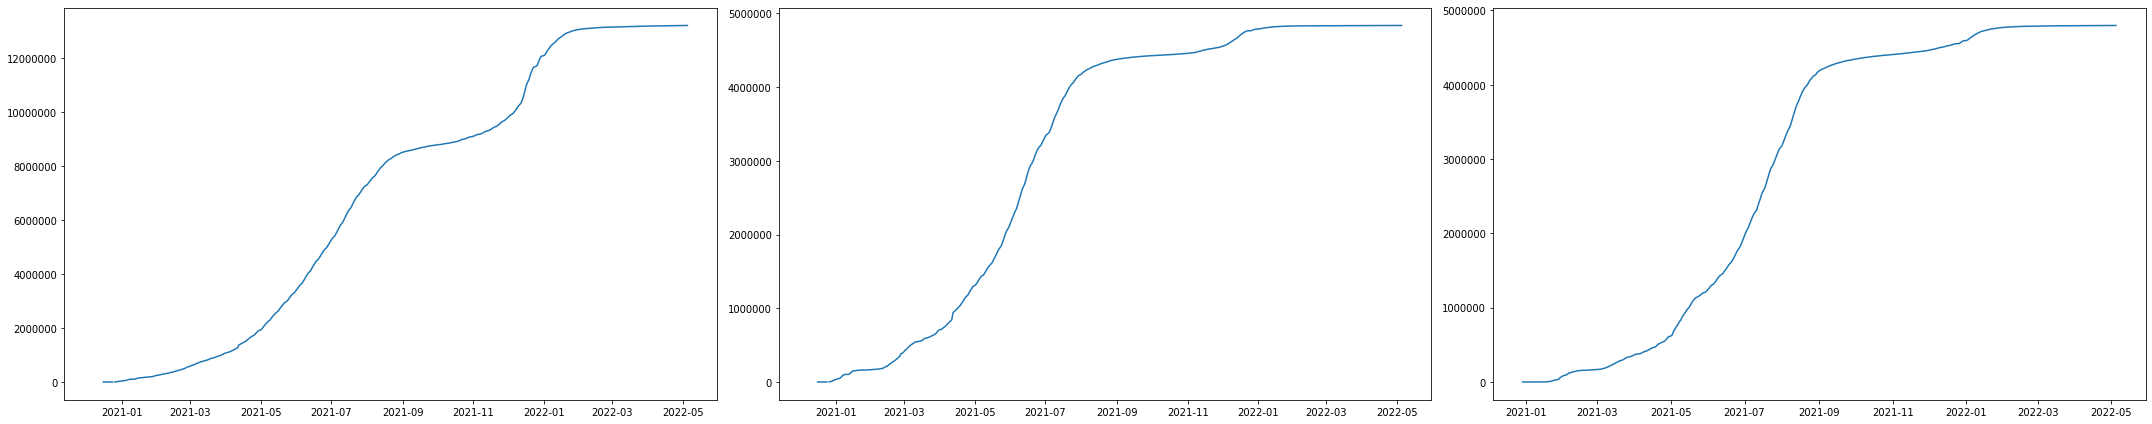

In [ ]:
plt.figure(figsize=(30,6))

plt.subplot(1, 3, 1)
plt.plot(df3.set_index('date')['vaccines'])
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()

plt.subplot(1, 3, 2)
plt.plot(df3.set_index('date')['people_vaccinated'])
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()

plt.subplot(1, 3, 3)
plt.plot(df3.set_index('date')['people_fully_vaccinated'])
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()

Braki danych z pierwszego roku pandemii(okresu bez szczepionek) uzupełniam 0. Pozostałe brakujące wartości wypełniam metodą interpolate

In [ ]:
df3['vaccines']=df3['vaccines'].mask(df3['vaccines'].ffill().isnull(), 0)
df3['people_vaccinated']=df3['people_vaccinated'].mask(df3['people_vaccinated'].ffill().isnull(), 0)
df3['people_fully_vaccinated']=df3['people_fully_vaccinated'].mask(df3['people_fully_vaccinated'].ffill().isnull(), 0)

In [ ]:
df3['vaccines']=df3['vaccines'].interpolate()
df3['people_vaccinated']=df3['people_vaccinated'].interpolate()
df3['people_fully_vaccinated']=df3['people_fully_vaccinated'].interpolate()

In [ ]:
df3['vaccines']=df3['vaccines'].round()
df3['people_vaccinated']=df3['people_vaccinated'].round()
df3['people_fully_vaccinated']=df3['people_fully_vaccinated'].round()

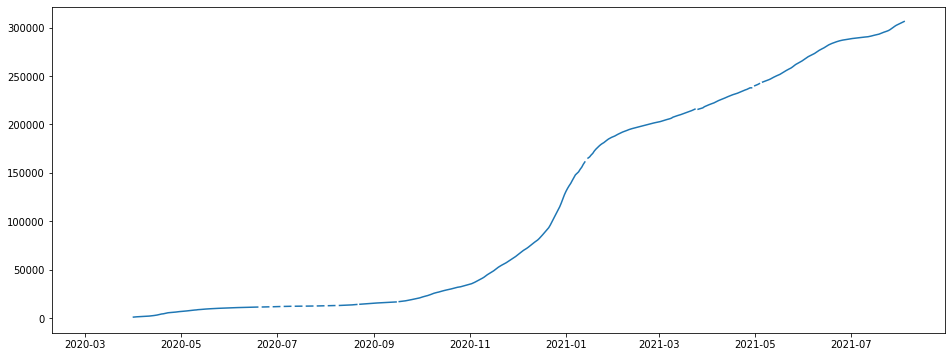

In [ ]:
fig, ax = plt.subplots(figsize = (16,6))
ax.plot(df3.set_index('date')['recovered'])
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Braki danych z początku pandemii wypełniam wartością 0. Następnie braki z okresu od 05.2020 do 07.2021 uzupełniam metodą interpolate, która działa z ograniczeniem wstecz, tak żeby nie uzupełniła braków od lipca 2021.

In [ ]:
df3['recovered'] = df3['recovered'].mask(df3['recovered'].ffill().isnull(), 0)

In [ ]:
df3['recovered']=df3['recovered'].interpolate(limit_direction='backward')

Brakujące dane od 07.2021 do 05.2020 uzupełniam korzystając z własności, że 'recovered' jest silnie skorelowana ze zmienną 'confirmed' - korelacja o wartości 0.8. Przyglądając się danym łatwo wyciągnąć wniosek -im więcej potwierdzonych przypadków tym więcej zdiagnzowanych uzdrowień. Więc tutaj bierzemy pod uwagę wiele funkcji, stosując podejście wielowymiarowe- korzystam z Iterative Imputer

Zmienną 'confirmed' przesuwam o 10 dni w czasie, ponieważ mniej więcej po tym czasie osoby zdiagnozowane wyzdrowiały

In [ ]:
cols = [ 'recovered', 'confirmed']
X = df3[cols]
X['confirmed']=X['confirmed'].shift(periods=10,fill_value=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
impute_it = IterativeImputer()
dd=impute_it.fit_transform(X)
df3['recovered']=dd[:,0].round(0)

In [ ]:
df3['recovered']=df3['recovered'].round()

Zmieniam dane kumulatywne na dane dzienne, ponieważ daje to lepszy rezultat w dalszych etapach projektu 

In [ ]:
for x in ['confirmed','deaths','recovered','tests','vaccines','people_vaccinated','people_fully_vaccinated']:
  df3[x]=df3[x]-df3[x].shift(1,fill_value=0)

In [ ]:
df3[['confirmed','deaths','recovered','tests','vaccines','people_vaccinated','people_fully_vaccinated']]= df3[['confirmed','deaths','recovered','tests','vaccines','people_vaccinated','people_fully_vaccinated']].mask(df3[['confirmed','deaths','recovered','tests','vaccines','people_vaccinated','people_fully_vaccinated']] < 0)

In [ ]:
percent_missing(df3)

confirmed    0.125628
deaths       0.125628
recovered    0.376884
dtype: float64

In [ ]:
for x in percent_missing(df3).index.tolist():
  df3[x]=df3[x].interpolate(limit_direction="both")

In [ ]:
percent_missing(df3)

Series([], dtype: float64)

In [ ]:
df3=df3.round()



---
PODSTAWOWA EKSPLORACJA DANYCH


---




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


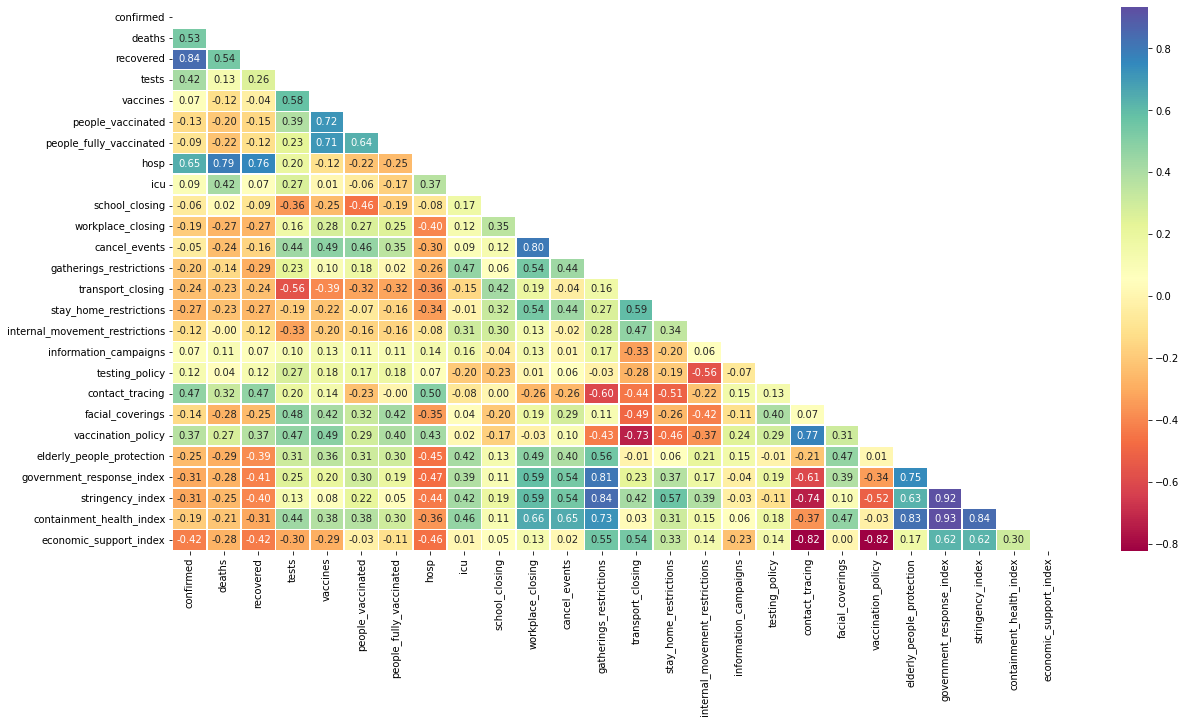

In [ ]:
corr_dania =  df3.corr() 
mask_ut=np.triu(np.ones(corr_dania.shape)).astype(np.bool)
fig, ax = plt.subplots( figsize=(20,10) )
sns.heatmap(corr_dania, mask=mask_ut,annot=True, linewidths=.5, fmt='.2f',ax=ax, cmap="Spectral")

In [ ]:
df3.info()
df3.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 796 entries, 156302 to 157100
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            796 non-null    datetime64[ns]
 1   confirmed                       796 non-null    float64       
 2   deaths                          796 non-null    float64       
 3   recovered                       796 non-null    float64       
 4   tests                           796 non-null    float64       
 5   vaccines                        796 non-null    float64       
 6   people_vaccinated               796 non-null    float64       
 7   people_fully_vaccinated         796 non-null    float64       
 8   hosp                            796 non-null    float64       
 9   icu                             796 non-null    float64       
 10  school_closing                  796 non-null    float64       
 11

,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,hosp,icu,school_closing,...,information_campaigns,testing_policy,contact_tracing,facial_coverings,vaccination_policy,elderly_people_protection,government_response_index,stringency_index,containment_health_index,economic_support_index
count,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,...,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000
mean,3923.954774,7.825377,3847.688442,84352.307789,16602.143216,6074.934673,6026.604271,351.276382,36.662060,0.668342,...,1.844221,2.787688,1.346734,1.456030,2.653266,1.561558,51.131910,47.062814,51.805276,46.261307
std,9687.306468,12.494362,9538.433285,69383.910760,25759.400912,11506.247255,11467.734207,392.599495,32.767028,1.620017,...,0.774340,0.605135,0.476229,0.979963,2.213254,0.754011,12.110557,17.583113,11.385350,36.665300
min,0.000000,0.000000,0.000000,49.000000,0.000000,0.000000,0.000000,12.000000,0.000000,-3.000000,...,-2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,9.000000,11.000000,11.000000,0.000000
25%,222.750000,1.000000,194.250000,24159.500000,0.000000,0.000000,0.000000,95.000000,15.000000,0.000000,...,2.000000,3.000000,1.000000,0.000000,0.000000,1.000000,48.000000,39.000000,47.000000,0.000000
50%,703.000000,3.000000,678.000000,68976.000000,3574.000000,272.500000,424.000000,191.000000,28.000000,1.000000,...,2.000000,3.000000,1.000000,2.000000,3.000000,2.000000,54.000000,51.000000,54.000000,50.000000
75%,1727.250000,11.000000,1613.250000,132737.250000,22160.000000,6205.500000,5859.500000,466.500000,44.000000,2.000000,...,2.000000,3.000000,2.000000,2.000000,5.000000,2.000000,59.000000,60.000000,60.000000,88.000000
max,60568.000000,171.000000,59608.000000,289233.000000,166685.000000,93068.000000,57425.000000,1762.000000,153.000000,3.000000,...,2.000000,3.000000,2.000000,3.000000,5.000000,3.000000,72.000000,72.000000,69.000000,100.000000




---
STANDARYZACJA DANYCH


---




In [ ]:
df_dania=df3.copy()

In [ ]:
date=df3.copy()
df_dania=df_dania.drop('date',axis=1)

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df_dania)
scaled_features = scaler.transform(df_dania)
df_d = pd.DataFrame(scaled_features,columns=df_dania.columns)




---


##**LOKALNA PREDYKCJA LICZBY ZACHOROWAŃ**


---




In [ ]:
corr_dania.sort_values('confirmed', ascending = False)['confirmed']

confirmed                         1.000000
recovered                         0.838962
hosp                              0.645245
deaths                            0.530486
contact_tracing                   0.469472
tests                             0.418804
vaccination_policy                0.368679
testing_policy                    0.118225
icu                               0.091414
information_campaigns             0.072682
vaccines                          0.069558
cancel_events                    -0.052440
school_closing                   -0.060418
people_fully_vaccinated          -0.093741
internal_movement_restrictions   -0.118367
people_vaccinated                -0.134653
facial_coverings                 -0.138514
workplace_closing                -0.187345
containment_health_index         -0.188432
gatherings_restrictions          -0.199741
transport_closing                -0.236542
elderly_people_protection        -0.248951
stay_home_restrictions           -0.272509
government_



---
PODZIAŁ DANYCH


---




Do dalszej analizy wybieram tylko te dane, które miały największą korelację ze zmienną 'confirmed'

In [ ]:
X=df_d[['recovered','hosp','deaths','contact_tracing','tests','vaccination_policy','testing_policy','icu','information_campaigns','vaccines']]
Y=df_d['confirmed']
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.30, shuffle=False,stratify=None)
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.30, random_state=20)



---
REGRESJA LINIOWA


---




In [ ]:
data_frame3=pd.DataFrame(columns=["R2 score", "RMSE","MAE", "MSE"])

In [ ]:
for x in ['recovered','hosp','deaths','contact_tracing','tests','vaccination_policy','testing_policy','icu','information_campaigns','vaccines']:
    LR=LinearRegression()
    LR.fit(X_train[x].values.reshape(-1,1),y_train)
    pred=LR.predict(X_test[x].values.reshape(-1,1))

    df2 = pd.DataFrame({"R2 score":metrics.r2_score(y_test, pred).round(4),
                                  "RMSE": np.sqrt(metrics.mean_squared_error(y_test, pred)).round(4),
                                  "MAE":metrics.mean_absolute_error(y_test, pred).round(4),
                                  "MSE": metrics.mean_squared_error(y_test, pred).round(4)}, index ={x})
    data_frame3=data_frame3.append(df2)

In [ ]:
data_frame3.sort_values(by="R2 score",ascending=False)


,R2 score,RMSE,MAE,MSE
recovered,0.7745,0.5183,0.1960,0.2686
hosp,0.4690,0.7953,0.4115,0.6325
deaths,0.2742,0.9298,0.4501,0.8645
contact_tracing,0.2382,0.9526,0.4356,0.9074
vaccination_policy,0.1365,1.0142,0.5496,1.0286
tests,0.1343,1.0155,0.5390,1.0313
testing_policy,0.0139,1.0838,0.5809,1.1747
information_campaigns,0.0040,1.0893,0.5787,1.1865
icu,-0.0131,1.0986,0.5877,1.2068
vaccines,-0.0189,1.1017,0.5823,1.2137




---
SPRAWDZENIE ZAŁOŻEŃ REGRESJI LINIOWEJ


---




Najwyższy wynik r2 score uzyskałam zmienną 'recovered' i to dla niej sprawdzam założenia regresji liniowej

In [ ]:
LR=LinearRegression()

LR.fit(X_train['recovered'].values.reshape(-1,1),y_train)
pred_lr=LR.predict(X_test['recovered'].values.reshape(-1,1))

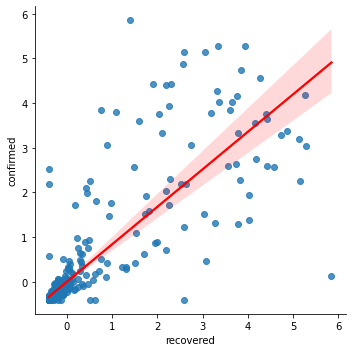

In [ ]:
sns.lmplot(x='recovered',y='confirmed',data=df_d,line_kws={'color': 'red'})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of residuals')

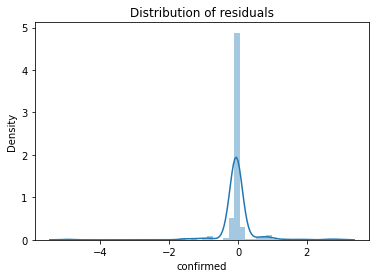

In [ ]:
residuals = y_test-pred_lr
sns.distplot(residuals,kde=True)
plt.title('Distribution of residuals')

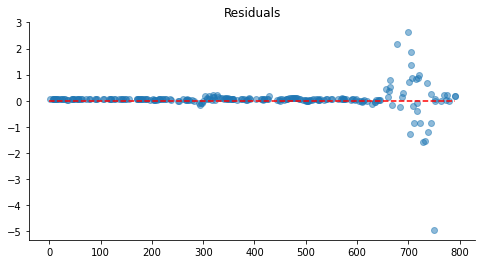

In [ ]:
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': pred_lr})
df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])  
plt.subplots(figsize=(8, 4))
ax = plt.subplot(111)  
plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
plt.plot(np.repeat(0, df_results.index.max()), color='red', linestyle='--')
ax.spines['right'].set_visible(False)  
ax.spines['top'].set_visible(False)  
plt.title('Residuals')
plt.show() 

Nie wszystkie założenia regresji liniowej zostały spełnione. Zmienna 'recovered' nie wykazuje liniowej zależności ze zmienną confirmed, natomiast założenia dotyczące rozkładu błędów i homoskedastyczności zostały spełnione. Rozkład błędów przypomina rozkład normalny, a rezydua są równo rozproszone



---
REGRESJA WIELORAKA


---




/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


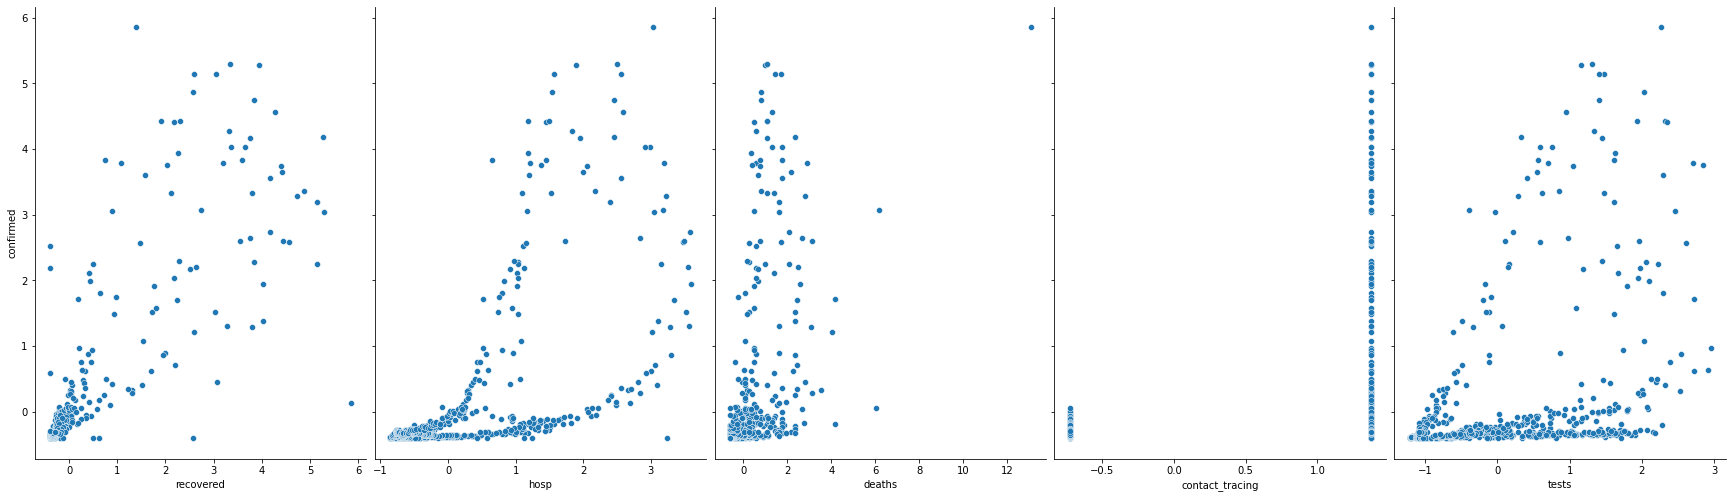

In [ ]:
sns.pairplot(df_d,x_vars=['recovered','hosp','deaths','contact_tracing','tests'],
             y_vars=['confirmed'],size=7,aspect=0.7)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


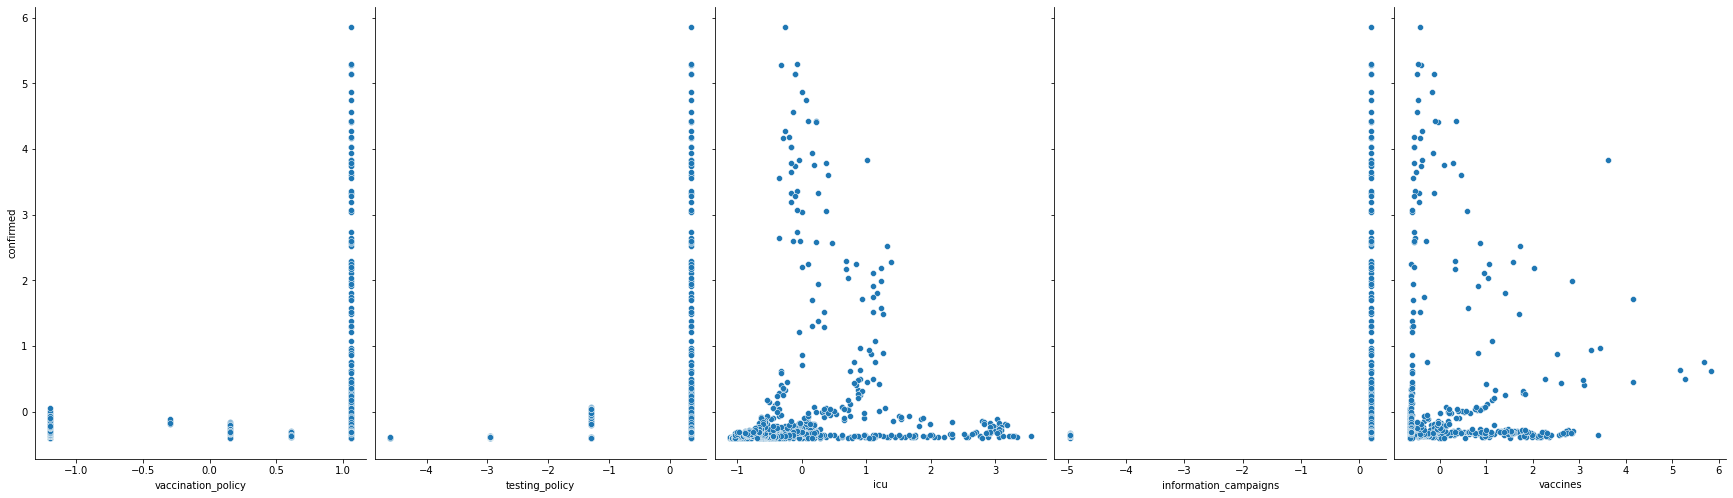

In [ ]:
sns.pairplot(df_d,x_vars=['vaccination_policy','testing_policy','icu','information_campaigns','vaccines'],
             y_vars=['confirmed'],size=7,aspect=0.7)

**Wybór parametrów do regresji wielorakiej:**

Współliniowość między zmiennymi jest słaba, dletego wybieram tylko te, które są w jakimś stopniu rozproszone po wykresie i skorelowane ze zmienną 'confired':'recovered','hosp','deaths','tests','icu' i 'vaccines'.

Nie mogą one wszystkie zostać wykorzystane do modelu ponieważ zmienne powinne być skorelowane z celem, a nie powinny być skorelowane ze sobą. Dlatego do modelu wybrałam tylko: 'recovered','tests','vaccines'

In [ ]:
LR2=LinearRegression()

model=LR2.fit(X_train[['recovered','tests','vaccines']],y_train)
predicted_mr=model.predict(X_test[['recovered','tests','vaccines']])
print('MAE:', metrics.mean_absolute_error(y_test, predicted_mr))
print('MSE:', metrics.mean_squared_error(y_test, predicted_mr))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted_mr)))
print('R2 score:', metrics.r2_score(y_test, predicted_mr))

print(f"Test score: {metrics.r2_score(y_test, predicted_mr)*100:.2f}%")

MAE: 0.2529223367665434
MSE: 0.24545575640107126
RMSE: 0.49543491641291415
R2 score: 0.7939486843645256
Test score: 79.39%




---
REGRESJA LINIOWA VS WIELORAKA - PORÓWNANIE


---



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

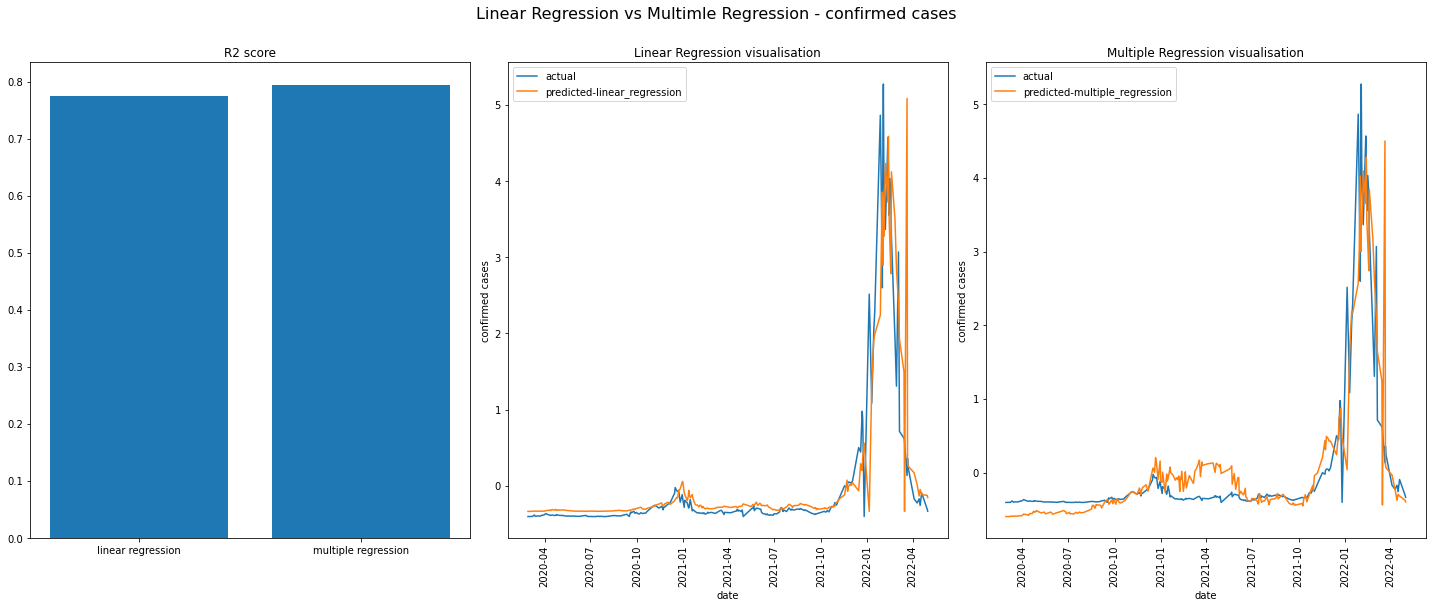

In [ ]:
plt.figure(figsize=(20,8))
plt.suptitle('Linear Regression vs Multimle Regression - confirmed cases', fontsize=16,y=1.05)

plt.subplot(1,3,1)
plt.title('R2 score')
l = ['linear regression','multiple regression']
r2 = [metrics.r2_score(y_test, pred_lr).round(4) , metrics.r2_score(y_test, predicted_mr).round(4)]
plt.bar(l,r2)

plt.subplot(1, 3, 2)
plt.title('Linear Regression visualisation')
sns.lineplot(date['date'].iloc[X_test.index].values,y_test)
sns.lineplot(date['date'].iloc[X_test.index].values,pred_lr)
plt.legend(labels=["actual","predicted-linear_regression"])

plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('confirmed cases')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.title('Multiple Regression visualisation')
sns.lineplot(date['date'].iloc[X_test.index].values,y_test)
sns.lineplot(date['date'].iloc[X_test.index].values,predicted_mr)
plt.legend(labels=["actual","predicted-multiple_regression"])

plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('confirmed cases')
plt.tight_layout()


Regresja liniowa i wieloraka w lokalnej predykcji zachorowań dają podobne rezultaty-minimalnie lepsza jest regresja wieloraka-różnica ok.2 punktów procentowych. Wyniki obu regresji są zadowalające, jednak nie są idealne. Dopasowanie wartości przewidzianych do aktualnych w obu przypadkach ma rozbieżności od danych aktualnych.Dużą rozbieżność między danymi widać na wykresie regresji wielorakiej m.in w okresie 2021.01-2021.07 - na tym fragmencie wypadła gorzej od regresji liniowej


---


DZIAŁANIE ALGORYTMÓW:SVR, DRZEW REGRESYJNYCH,LOSOWEGO LASU REGRESYJNEGO


---





In [ ]:
df_lc=pd.DataFrame(columns=["R2 score", "RMSE","MAE", "MSE"])

In [ ]:
from sklearn.svm import SVR
SVR = SVR()

model=SVR.fit(X_train[['recovered','tests','vaccines']],y_train)
predicted1a=model.predict(X_test[['recovered','tests','vaccines']])

df2 = pd.DataFrame({"R2 score":metrics.r2_score(y_test, predicted1a).round(4),
                                  "RMSE": np.sqrt(metrics.mean_squared_error(y_test, predicted1a)).round(4),
                                  "MAE":metrics.mean_absolute_error(y_test, predicted1a).round(4),
                                  "MSE": metrics.mean_squared_error(y_test, predicted1a).round(4)}, index ={'SVR'})
df_lc=df_lc.append(df2)

In [ ]:
tree_reg =  DecisionTreeRegressor()

model=tree_reg.fit(X_train[['recovered','tests','vaccines']],y_train)
predicted2a=model.predict(X_test[['recovered','tests','vaccines']])
df2 = pd.DataFrame({"R2 score":metrics.r2_score(y_test, predicted2a).round(4),
                                  "RMSE": np.sqrt(metrics.mean_squared_error(y_test, predicted2a)).round(4),
                                  "MAE":metrics.mean_absolute_error(y_test, predicted2a).round(4),
                                  "MSE": metrics.mean_squared_error(y_test, predicted2a).round(4)}, index ={'Decision Tree Regressor'})
df_lc=df_lc.append(df2)

In [ ]:
forest_reg = RandomForestRegressor()

model=forest_reg.fit(X_train[['recovered','tests','vaccines']],y_train)
predicted3a=model.predict(X_test[['recovered','tests','vaccines']])
df2 = pd.DataFrame({"R2 score":metrics.r2_score(y_test, predicted3a).round(4),
                                  "RMSE": np.sqrt(metrics.mean_squared_error(y_test, predicted3a)).round(4),
                                  "MAE":metrics.mean_absolute_error(y_test, predicted3a).round(4),
                                  "MSE": metrics.mean_squared_error(y_test, predicted3a).round(4)}, index ={'Random Forest Regressor'})
df_lc=df_lc.append(df2)

In [ ]:
df_lc.sort_values(by="R2 score",ascending=False)

,R2 score,RMSE,MAE,MSE
SVR,0.9012,0.3431,0.1442,0.1177
Random Forest Regressor,0.8695,0.3943,0.1398,0.1554
Decision Tree Regressor,0.8279,0.4527,0.1615,0.2050


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

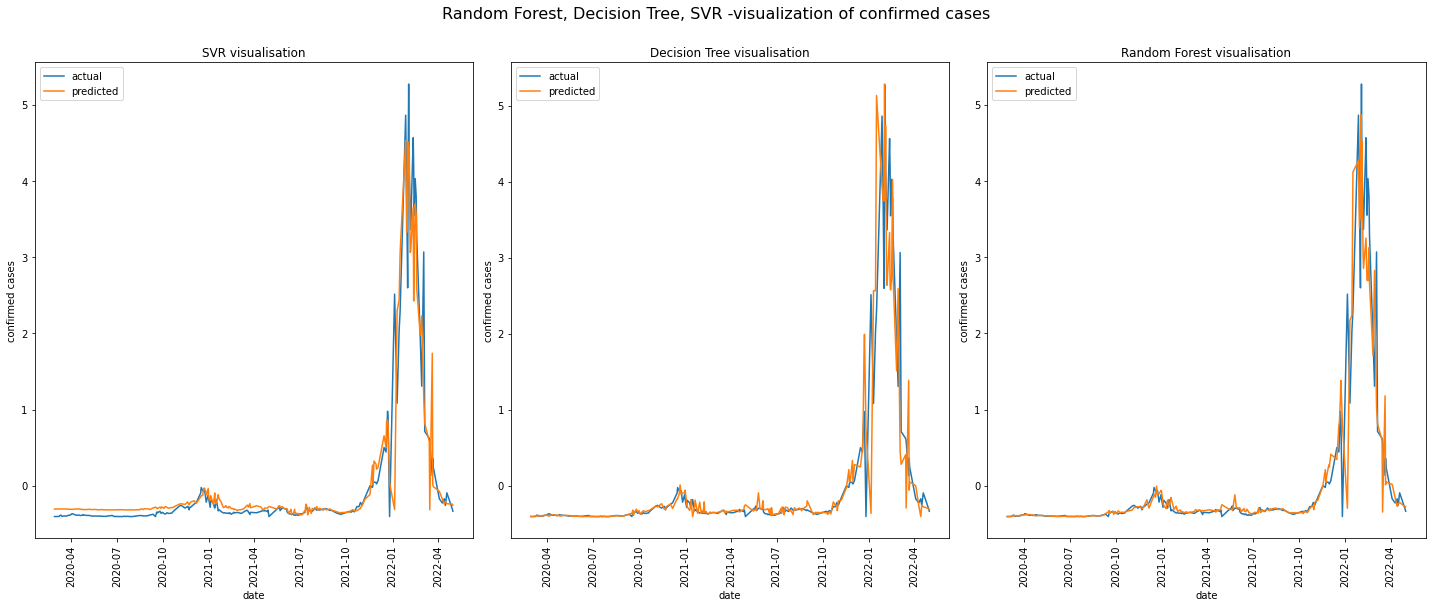

In [ ]:
plt.figure(figsize=(20,8))
plt.suptitle('Random Forest, Decision Tree, SVR -visualization of confirmed cases', fontsize=16,y=1.05)

plt.subplot(1, 3, 1)
plt.title('SVR visualisation')
sns.lineplot(date['date'].iloc[X_test.index].values,y_test)
sns.lineplot(date['date'].iloc[X_test.index].values,predicted1a)
plt.legend(labels=["actual","predicted"])

plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('confirmed cases')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.title('Decision Tree visualisation')
sns.lineplot(date['date'].iloc[X_test.index].values,y_test)
sns.lineplot(date['date'].iloc[X_test.index].values,predicted2a)
plt.legend(labels=["actual","predicted"])

plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('confirmed cases')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.title('Random Forest visualisation')
sns.lineplot(date['date'].iloc[X_test.index].values,y_test)
sns.lineplot(date['date'].iloc[X_test.index].values,predicted3a)
plt.legend(labels=["actual","predicted"])

plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('confirmed cases')
plt.tight_layout()

Wszystkie wyniki są satysfakcjonujące i wysokie-powyżej 80%. Najwyższy wynik miał SVR. Mimo że Random Forest uplansował się na 2 miejscu pod względem wyniku R2 score, ma on zdecydowanie lepszy rezultat dla okresu 2020-04 do 2020-01 od algorytmu SVR.



---
##**LOKALNA PREDYKCJA LICZBY ŚMIERCI SPOWODOWANEJ COVID-19**


---




In [ ]:
corr_dania.sort_values('deaths', ascending = False)['deaths']

deaths                            1.000000
hosp                              0.792115
recovered                         0.537839
confirmed                         0.530486
icu                               0.415423
contact_tracing                   0.319254
vaccination_policy                0.268683
tests                             0.125000
information_campaigns             0.106916
testing_policy                    0.044335
school_closing                    0.024603
internal_movement_restrictions   -0.000358
vaccines                         -0.121114
gatherings_restrictions          -0.140269
people_vaccinated                -0.202602
containment_health_index         -0.212794
people_fully_vaccinated          -0.220843
stay_home_restrictions           -0.226503
transport_closing                -0.226845
cancel_events                    -0.242550
stringency_index                 -0.253572
workplace_closing                -0.267583
facial_coverings                 -0.276517
government_

Do dalszej analizy wybieram tylko te zmienne, które wykazują najwyższą wartość korelacji ze zmienną 'deaths'

In [ ]:
X=df_d[['hosp','recovered','confirmed','icu','contact_tracing','vaccination_policy','tests']]
Y=df_d['deaths']

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.30,random_state=20)



---
REGRESJA LINIOWA


---




In [ ]:
data_frame4=pd.DataFrame(columns=["R2 score", "RMSE","MAE", "MSE"])

In [ ]:
for x in ['hosp','recovered','confirmed','icu','contact_tracing','vaccination_policy','tests']:
    LR=LinearRegression()

    LR.fit(X_train[x].values.reshape(-1, 1),y_train)
    pred=LR.predict(X_test[x].values.reshape(-1,1))

    df2 = pd.DataFrame({"R2 score":metrics.r2_score(y_test, pred).round(4),
                                  "RMSE": np.sqrt(metrics.mean_squared_error(y_test, pred)).round(4),
                                  "MAE":metrics.mean_absolute_error(y_test, pred).round(4),
                                  "MSE": metrics.mean_squared_error(y_test, pred).round(4)}, index ={x})
    data_frame4=data_frame4.append(df2)

In [ ]:
data_frame4.sort_values(by="R2 score",ascending=False)

,R2 score,RMSE,MAE,MSE
hosp,0.7381,0.4920,0.2784,0.2421
recovered,0.3019,0.8033,0.5521,0.6454
confirmed,0.2707,0.8211,0.5607,0.6742
icu,0.2595,0.8274,0.5182,0.6846
contact_tracing,0.0849,0.9198,0.6202,0.8460
vaccination_policy,0.0569,0.9338,0.6637,0.8719
tests,0.0138,0.9548,0.6750,0.9117




---


SPRAWDZENIE ZAŁOŻEŃ REGRESJI LINIOWEJ


---




Najlepszą zmienną dla regresji liniowej jest zmienna 'hosp', i to dla niej sprawdzam założenia regresji liniowej

In [ ]:
LR=LinearRegression()

LR.fit(X_train['hosp'].values.reshape(-1,1),y_train)
pred_lrd=LR.predict(X_test['hosp'].values.reshape(-1,1))

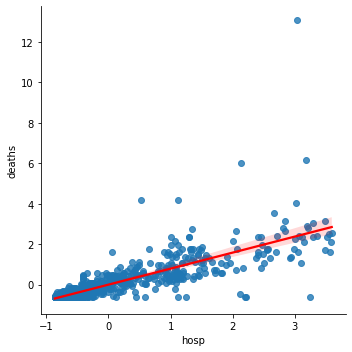

In [ ]:
sns.lmplot(x='hosp',y='deaths',data=df_d,line_kws={'color': 'red'})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of residuals')

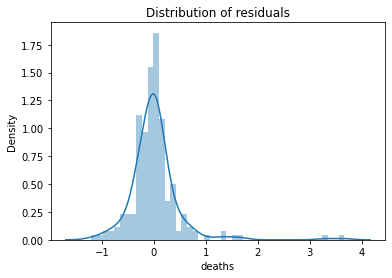

In [ ]:
residuals = y_test-pred_lrd

sns.distplot(residuals,kde=True)
plt.title('Distribution of residuals')

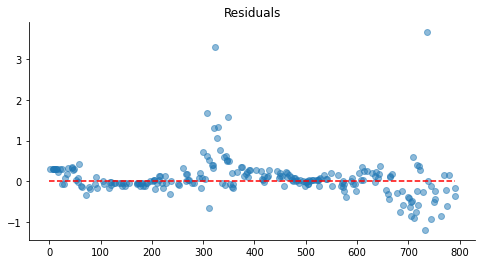

In [ ]:
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': pred_lrd})
df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])  
plt.subplots(figsize=(8, 4))
ax = plt.subplot(111)  
plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
plt.plot(np.repeat(0, df_results.index.max()), color='red', linestyle='--')
ax.spines['right'].set_visible(False)  
ax.spines['top'].set_visible(False)  
plt.title('Residuals')
plt.show() 

Wszystkie założenia regresji liniowej zostały spełnione - występuje liniowa zależność między zmiennymi, rozkład błędów jest rozkładem normalnym i rezydua sa równo rozproszone



---
REGRESJA WIELORAKA


---




/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


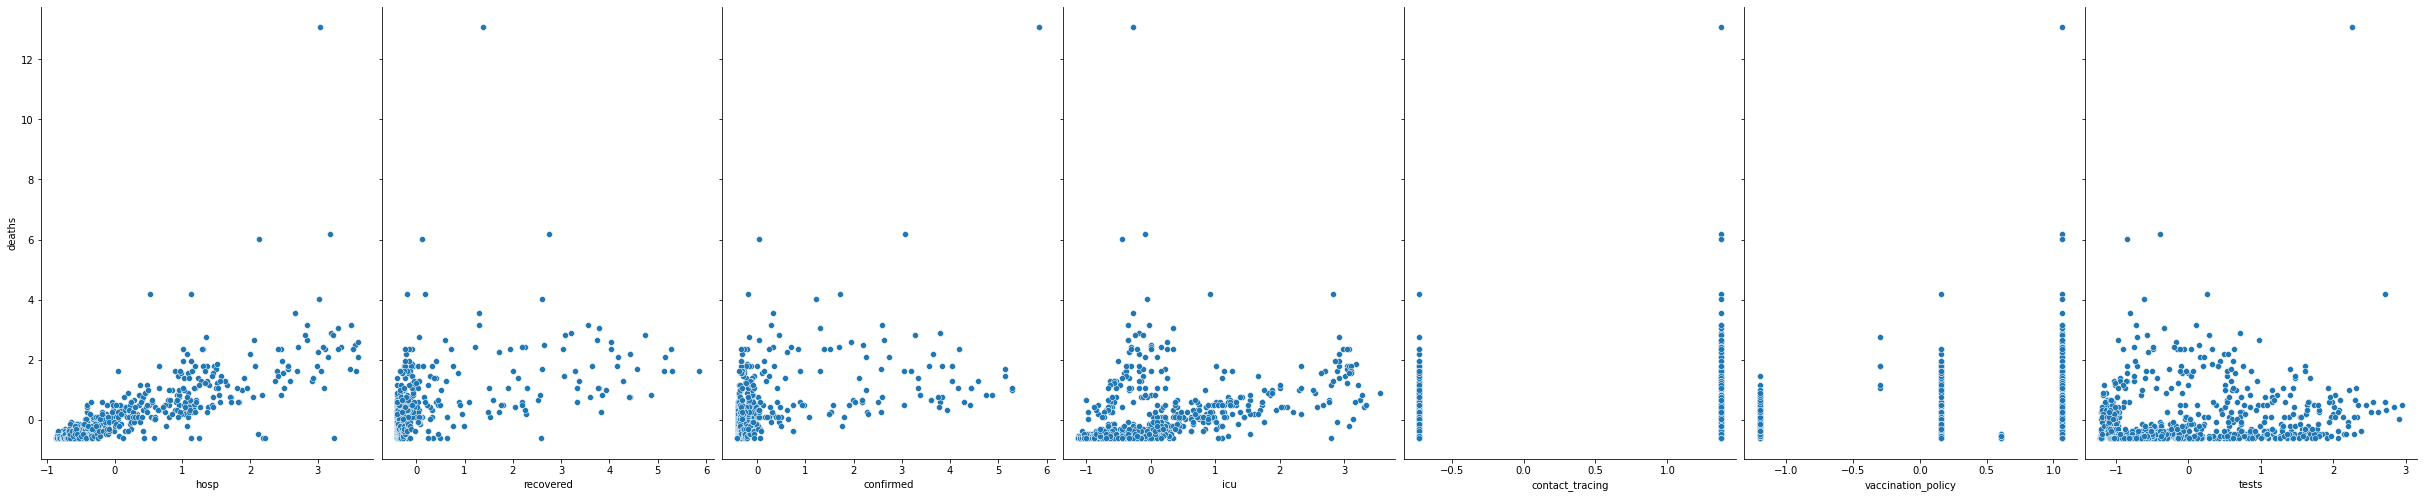

In [ ]:
sns.pairplot(df_d,x_vars=['hosp','recovered','confirmed','icu','contact_tracing','vaccination_policy','tests'],
             y_vars=['deaths'],size=7,aspect=0.7)

**Wybór parametrów do regresji wielorakiej:**

Zmienne które biorę pod uwagę do modelu regresji wielorakiej, to te, które wykazują w miarę liniową zależność i skorelowane ze zmienną 'death':'hosp','recovered','confirmed','icu' i 'tests'

Nie mogą one wszystkie zostać wykorzystane do modelu ponieważ zmienne powinne być skorelowane z celem, a nie powinny być skorelowane ze sobą. Dlatego do modelu wybieram:'hosp','icu','recovered','tests'

In [ ]:
LR2=LinearRegression()

model=LR2.fit(X_train[['hosp','icu','recovered','tests']],y_train)
predicted_mrd=model.predict(X_test[['hosp','icu','recovered','tests']])
print('MAE:', metrics.mean_absolute_error(y_test, predicted_mrd))
print('MSE:', metrics.mean_squared_error(y_test, predicted_mrd))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted_mrd)))
print('R2 score:', metrics.r2_score(y_test, predicted_mrd))

print(f"Test score: {metrics.r2_score(y_test, predicted_mrd)*100:.2f}%")

MAE: 0.24859072321247072
MSE: 0.20563281095102576
RMSE: 0.45346754123203326
R2 score: 0.7775745909787198
Test score: 77.76%




---
REGRESJA LINIOWA VS WIELORAKA - PORÓWNANIE


---



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

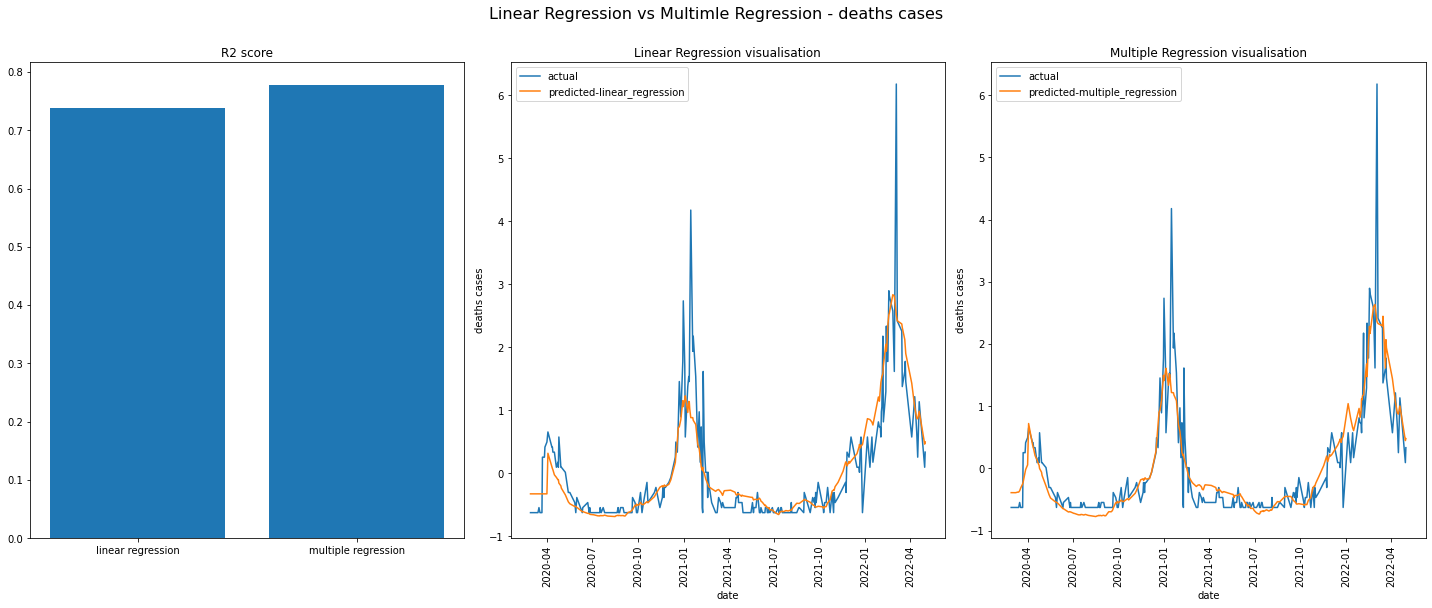

In [ ]:
plt.figure(figsize=(20,8))
plt.suptitle('Linear Regression vs Multimle Regression - deaths cases', fontsize=16,y=1.05)

plt.subplot(1,3,1)
plt.title('R2 score')
l = ['linear regression','multiple regression']
r2 = [metrics.r2_score(y_test, pred_lrd).round(4) , metrics.r2_score(y_test, predicted_mrd).round(4)]
plt.bar(l,r2)

plt.subplot(1, 3, 2)
plt.title('Linear Regression visualisation')
sns.lineplot(date['date'].iloc[X_test.index].values,y_test)
sns.lineplot(date['date'].iloc[X_test.index].values,pred_lrd)
plt.legend(labels=["actual","predicted-linear_regression"])

plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('deaths cases')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.title('Multiple Regression visualisation')
sns.lineplot(date['date'].iloc[X_test.index].values,y_test)
sns.lineplot(date['date'].iloc[X_test.index].values,predicted_mrd)
plt.legend(labels=["actual","predicted-multiple_regression"])

plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('deaths cases')
plt.tight_layout()

W predykcji liczby śmierci również lepiej wypadła regresja wieloraka- 78%, liniowa 74%. Wyniki w obu przypadkach są zadowalające. Ani regresja liniowa, ani wieloraka nie dopasowały się idealnie do danych aktualnych. Różnice pomiędzy wizualizacjami są bardzo małe.Najmocniej zauważalne rozbieżności pomiędzy obiema predykcjami widać na wykresie na przedziale 2020.07-2020.10 i okolicy 2021.07 - i są to wyniki na korzyść regresji liniowej pomimo, że miała niższy wynik.



---


DZIAŁANIE ALGORYTMÓW:SVR, DRZEW REGRESYJNYCH,LOSOWEGO LASU REGRESYJNEGO


---



In [ ]:
df_ld=pd.DataFrame(columns=["R2 score", "RMSE","MAE", "MSE"])

In [ ]:
from sklearn.svm import SVR
SVR = SVR()

model=SVR.fit(X_train[['hosp','icu','recovered','tests']],y_train)
predicted1b=model.predict(X_test[['hosp','icu','recovered','tests']])
df2 = pd.DataFrame({"R2 score":metrics.r2_score(y_test, predicted1b).round(4),
                                  "RMSE": np.sqrt(metrics.mean_squared_error(y_test, predicted1b)).round(4),
                                  "MAE":metrics.mean_absolute_error(y_test, predicted1b).round(4),
                                  "MSE": metrics.mean_squared_error(y_test, predicted1b).round(4)}, index ={'SVR'})
df_ld=df_ld.append(df2)

In [ ]:
tree_reg =  DecisionTreeRegressor()

model=tree_reg.fit(X_train[['hosp','icu','recovered','tests']],y_train)
predicted2b=model.predict(X_test[['hosp','icu','recovered','tests']])
df2 = pd.DataFrame({"R2 score":metrics.r2_score(y_test, predicted2b).round(4),
                                  "RMSE": np.sqrt(metrics.mean_squared_error(y_test, predicted2b)).round(4),
                                  "MAE":metrics.mean_absolute_error(y_test, predicted2b).round(4),
                                  "MSE": metrics.mean_squared_error(y_test, predicted2b).round(4)}, index ={'Decision Tree Regressor'})
df_ld=df_ld.append(df2)

In [ ]:
forest_reg = RandomForestRegressor()

model=forest_reg.fit(X_train[['hosp','icu','recovered','tests']],y_train)
predicted3b=model.predict(X_test[['hosp','icu','recovered','tests']])
df2 = pd.DataFrame({"R2 score":metrics.r2_score(y_test, predicted3b).round(4),
                                  "RMSE": np.sqrt(metrics.mean_squared_error(y_test, predicted3b)).round(4),
                                  "MAE":metrics.mean_absolute_error(y_test, predicted3b).round(4),
                                  "MSE": metrics.mean_squared_error(y_test, predicted3b).round(4)}, index ={'Random Forest Regressor'})
df_ld=df_ld.append(df2)

In [ ]:
df_ld.sort_values(by="R2 score",ascending=False)

,R2 score,RMSE,MAE,MSE
SVR,0.8247,0.4026,0.2052,0.1621
Random Forest Regressor,0.7297,0.4999,0.2388,0.2499
Decision Tree Regressor,0.4605,0.7062,0.3230,0.4988


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

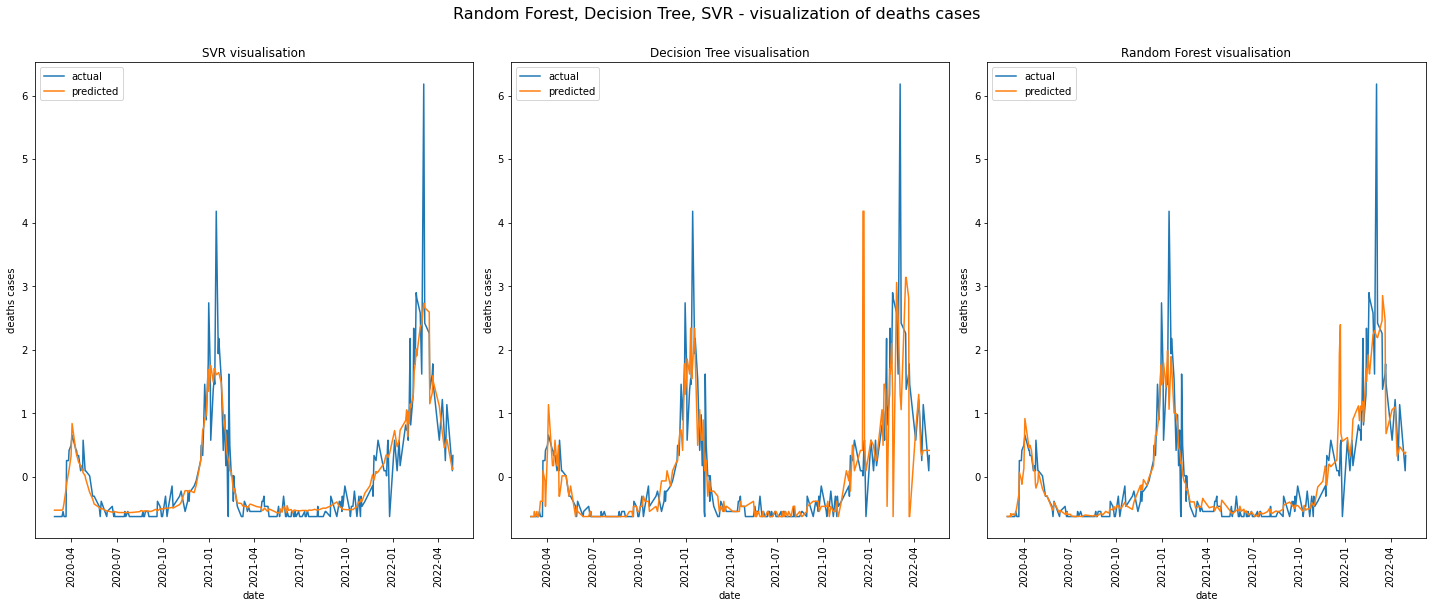

In [ ]:
plt.figure(figsize=(20,8))
plt.suptitle('Random Forest, Decision Tree, SVR - visualization of deaths cases', fontsize=16,y=1.05)

plt.subplot(1, 3, 1)
plt.title('SVR visualisation')
sns.lineplot(date['date'].iloc[X_test.index].values,y_test)
sns.lineplot(date['date'].iloc[X_test.index].values,predicted1b)
plt.legend(labels=["actual","predicted"])

plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('deaths cases')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.title('Decision Tree visualisation')
sns.lineplot(date['date'].iloc[X_test.index].values,y_test)
sns.lineplot(date['date'].iloc[X_test.index].values,predicted2b)
plt.legend(labels=["actual","predicted"])

plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('deaths cases')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.title('Random Forest visualisation')
sns.lineplot(date['date'].iloc[X_test.index].values,y_test)
sns.lineplot(date['date'].iloc[X_test.index].values,predicted3b)
plt.legend(labels=["actual","predicted"])

plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('deaths cases')
plt.tight_layout()

Ponownie dla predykcji z danych lokalnych najwyższy wynik uzyskał algorytm SVR. Najgorszy wynik miał algorytm drzew decyzyjnych i faktycznie, możemy zaobserwować na wykresie widoczne mocno odstające wartości(01.2022 - 04.2022) 



---
SVR, RANDOM FOREST, DECISION TREE- PORÓWNANIE LOKALNYCH I GLOBALNYCH WYNIKÓW

---




In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

label = ['SVR', 'Decision Tree','Random Forest']
fig = make_subplots(rows=1, cols=2,subplot_titles=('R2 score for confirmed prediction[%]','R2 score for death prediction[%]'))

gc=df_gc['R2 score'][0:].values*100
gd=df_gd['R2 score'][0:].values*100
lc=df_lc['R2 score'][0:].values*100
ld=df_ld['R2 score'][0:].values*100

fig.add_trace(go.Bar(x=label, y=gc.tolist(),
                base=0,
                marker_color='plum',
                name='global data'),row=1, col=1)
fig.add_trace(go.Bar(x=label, y=lc.tolist(),
                base=0,
                marker_color='lightslategrey',
                name='local data'
                ),row=1, col=1)

fig.update_layout(yaxis_range=[0,100])

fig.add_trace(go.Bar(x=label, y=gd.tolist(),
                base=0,
                marker_color='plum',name='global data',showlegend=False),row=1, col=2)

fig.add_trace(go.Bar(x=label, y=ld.tolist(),
                base=0,
                marker_color='lightslategrey',name='local data',showlegend=False),row=1, col=2)

fig.update_yaxes(range = [0,100])
fig.show()


Algorytmy SVR, Random Forest i Decision Tree poradziły sobie lepiej, zarówno z lokalnymi jak i globalnymi danymi, niż algorytmy regresji liniowej i wielorakiej.

Najlepsze rezultaty dla danych globalnych wykazał Random Forest-84% R2 przy predykcji liczby śmierci i ok.91% przy predykcji zachorowań - predykcje globalne wykonane tym algorytmem dałyby najlepsze rezultaty. Najsłabsze efekty dla danych globalnych uzyskane zostały algorytmem SVR.

Jeżeli chodzi o dane lokalne to w predykcji liczby zachorowań i śmierci najlepsze rezultaty wykazał algorytm SVR, co było dużym zaskoczeniem, minimalnie gorzej wypadł Random Forest.


Najbardziej uniwersalnym algorytmem do modelowania danych globalnych jak i lokalnych okazał się Random Forest, w obu przypadkach dał wysokie wyniki - jest on dokładny i wydajny dla większości problemów. Najgorzej z danymi poradził sobie algorytm Decision Tree. Zarówno w predykcji globalnej jak i lokalnej słapsze rezultaty uzyskano w predykcji liczby śmierci, wynikało to z faktu że zmienne wpływające na śmierć miały duże braki danych.





---
##**PODSUMOWANIE PROJEKTU**


---






> Głównym celem projektu było przeprowadzenie analizy porównawczej wybranych metod uczenia maszynowego wykorzystując do tego lokalny i globalny zbiór danych. Najpierw wykonana została eksploracyjna analiza zbiorów danych i uzupełnienie brakujących wartości, które stanowiły znaczną część danych(duży odsetek brakujących wartości był w danych globalnych), a następnie zaimplementowano algorytmy predykcyjne i sprawdzono ich działanie.





> Wykorzystanie algorytmów opartych na regresji w rozwiązaniu problemu było dobrym wyborem, co potwierdziły wyniki modelów opartych na lasach. Zdecydowanie lepsze rezultaty uzyskano przewidując liczbę zachorowań ,zarówno w zbiorze lokalnym jak i globalnym. Niższe wyniki w predykcji śmiertelnych przypadków, wynikały ze słabej korelacji zmiennych objaśniających ze zmienną objaśnianą.
W celu polepszenia wyników można byłoby poświęcić więcej czasu wypełnianiu wartości NaN –zrobić to dokładniej np. analizując i wypełniając braki pod kątem każdego z państw.
Problem można rozpatrywać globalnie, ale trzeba mieć na uwadze dużą rozbieżność w podejściu do pandemii COVID, jej zwalczania i zbierania danych pomiędzy krajami. Niektóre robiły to skrupulatnie, inne zakłamywały statystyki. Żeby mieć naprawdę dobre i wnikliwe wyniki, trzeba byłoby pogrupować w odpowiedni sposób kraje, np. na te słabo i mocno rozwinięte lub tak, aby czynniki mocno skorelowane ze zmienną prognozowaną były takie same w państwach, które znajdują się w zbiorze danych.
Po wykonaniu powyższej analizy można stwierdzić, że największą rolę w walce z chorobą odegrały testy(zostały wykorzystane w każdym modelu). Ciężko znaleźć jakieś spostrzeżenia dotyczące liczby zgonów i śmierci, bo zmieniały się one dynamicznie na przestrzeni czasu, a na ich ilość wpływały czynniki zewnętrzne takie jak np. pojawianie się nowych odmian COVID.

